## Import packages

In [ ]:
import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
import torch.optim as optim                             # Optimization algorithms
from torch import nn                                    # Neural network modules
from torch.utils.data import Dataset, DataLoader        # Dataset and batch data loading
from datetime import datetime                           # Date/time utilities
import os                                               # Operating system utilities
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data


3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


If using Google Colab, uncomment the following lines

In [340]:
# from google.colab import drive
# drive.mount('/content/drive')

# Prepare data

## Set paths to data

In [341]:
# select the id to train the model on
buffalo_id = 2005
n_samples = 10297

# Specify the path to CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Path to your TIF file
ndvi_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_ndvi_cent101x101_lag_1hr_n{n_samples}.tif'
# Path to your TIF file
canopy_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_canopy_cent101x101_lag_1hr_n{n_samples}.tif'
# Path to your TIF file
herby_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_herby_cent101x101_lag_1hr_n{n_samples}.tif'
# Path to your TIF file
slope_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_slope_cent101x101_lag_1hr_n{n_samples}.tif'

# Path to your TIF file
pres_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_pres_cent101x101_lag_1hr_n{n_samples}.tif'

## Read data

In [342]:
# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)
print(buffalo_df.shape)

# Lag the values in column 'A' by one index to get the bearing of the previous step
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

(10103, 35)
             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

     cos_ta         x_min         x_max         y_min         y_max  s2_index  \
0  0.

# Spatial data

## NDVI

In [343]:
# Using rasterio
with rasterio.open(ndvi_path) as ndvi:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    ndvi_stack = ndvi.read([i for i in range(1, ndvi.count + 1)])

print(ndvi_stack.shape)

(10103, 101, 101)


### Normalise the layers

In [344]:
# Replace NaNs in the original array with -1, which represents water
ndvi_stack = np.nan_to_num(ndvi_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
ndvi_tens = torch.from_numpy(ndvi_stack)

# Print the shape of the PyTorch tensor
print(ndvi_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
ndvi_mean = torch.mean(ndvi_tens)
ndvi_max = torch.max(ndvi_tens)
ndvi_min = torch.min(ndvi_tens)
print("Mean = ", ndvi_mean)
print("Max = ", ndvi_max)
print("Min = ", ndvi_min)

# Normalizing the data
ndvi_tens_norm = (ndvi_tens - ndvi_min) / (ndvi_max - ndvi_min)
print("Mean = ", torch.mean(ndvi_tens_norm))
print("Max = ", torch.max(ndvi_tens_norm))
print("Min = ", torch.min(ndvi_tens_norm))

torch.Size([10103, 101, 101])
Mean =  tensor(0.3039)
Max =  tensor(0.8220)
Min =  tensor(-0.2772)
Mean =  tensor(0.5287)
Max =  tensor(1.)
Min =  tensor(0.)


Plot a single NDVI layer

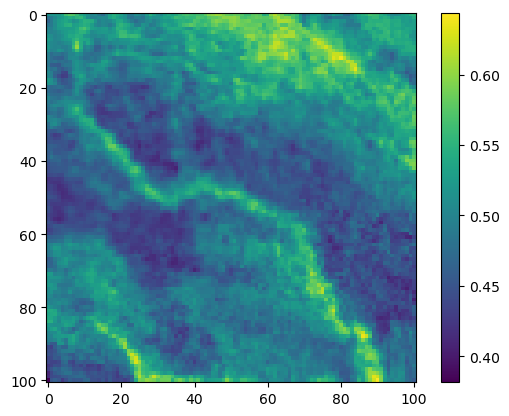

In [345]:
for i in range(0, 1):
    plt.imshow(ndvi_tens_norm[i].numpy())
    plt.colorbar()
    plt.show() 

## Canopy cover

In [346]:
# Using rasterio
with rasterio.open(canopy_path) as canopy:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    canopy_stack = canopy.read([i for i in range(1, canopy.count + 1)])

print(canopy_stack.shape)

(10103, 101, 101)


In [347]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
canopy_tens = torch.from_numpy(canopy_stack)
print(canopy_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
print("Mean = ", torch.mean(canopy_tens))
canopy_max = torch.max(canopy_tens)
canopy_min = torch.min(canopy_tens)
print("Max = ", canopy_max)
print("Min = ", canopy_min)

# Normalizing the data
canopy_tens_norm = (canopy_tens - canopy_min) / (canopy_max - canopy_min)
print("Mean = ", torch.mean(canopy_tens_norm))
print("Max = ", torch.max(canopy_tens_norm))
print("Min = ", torch.min(canopy_tens_norm))

torch.Size([10103, 101, 101])
Mean =  tensor(44.3548)
Max =  tensor(82.5000)
Min =  tensor(0.)
Mean =  tensor(0.5376)
Max =  tensor(1.)
Min =  tensor(0.)


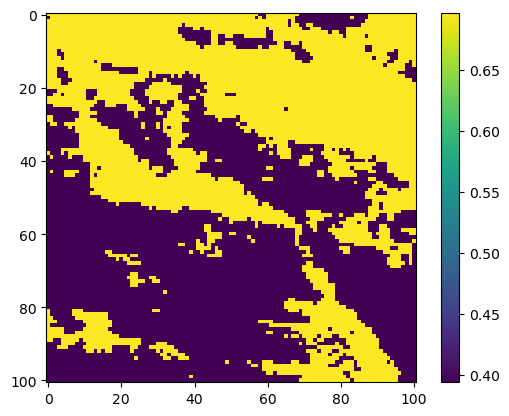

In [348]:
for i in range(0, 1):
    plt.imshow(canopy_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Herbaceous vegetation

In [349]:
# Using rasterio
with rasterio.open(herby_path) as herby:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    herby_stack = herby.read([i for i in range(1, herby.count + 1)])

print(herby_stack.shape)

(10103, 101, 101)


In [350]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
herby_tens = torch.from_numpy(herby_stack)
print(herby_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
print("Mean = ", torch.mean(herby_tens))
herby_max = torch.max(herby_tens)
herby_min = torch.min(herby_tens)
print("Max = ", herby_max)
print("Min = ", herby_min)

# Normalizing the data
herby_tens_norm = (herby_tens - herby_min) / (herby_max - herby_min)
print("Mean = ", torch.mean(herby_tens_norm))
print("Max = ", torch.max(herby_tens_norm))
print("Min = ", torch.min(herby_tens_norm))

torch.Size([10103, 101, 101])
Mean =  tensor(0.8069)
Max =  tensor(1.)
Min =  tensor(0.)
Mean =  tensor(0.8069)
Max =  tensor(1.)
Min =  tensor(0.)


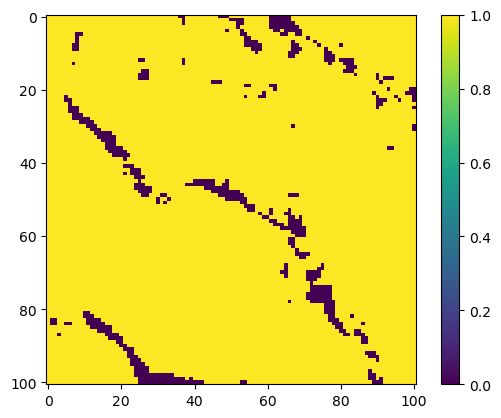

In [351]:
for i in range(0, 1):
    plt.imshow(herby_tens_norm[i])
    plt.colorbar()
    plt.show()

## Slope

In [352]:
# Using rasterio
with rasterio.open(slope_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(10103, 101, 101)


In [353]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
print("Mean = ", torch.mean(slope_tens))
slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)
print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens_norm = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens_norm))
print("Max = ", torch.max(slope_tens_norm))
print("Min = ", torch.min(slope_tens_norm))

torch.Size([10103, 101, 101])
Mean =  tensor(0.7779)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0632)
Max =  tensor(1.)
Min =  tensor(0.)


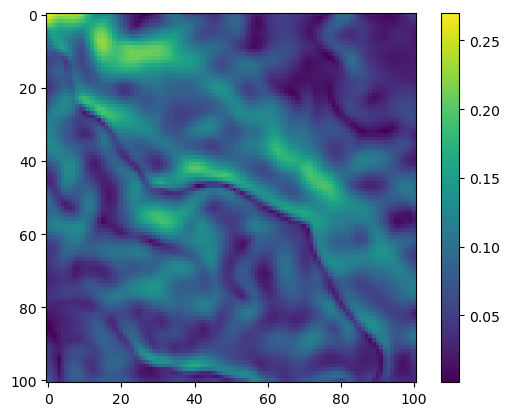

In [354]:
for i in range(0, 1):
    plt.imshow(slope_tens_norm[i])
    plt.colorbar()
    plt.show()

## Presence records - target of model

This is what the model is trying to predict, which is the location of the next step.

In [355]:
# Using rasterio
with rasterio.open(pres_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)

(10103, 101, 101)


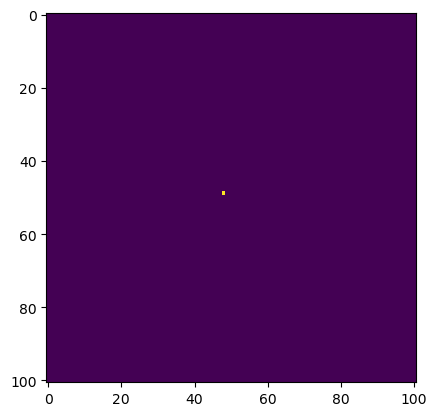

In [356]:
for i in range(0, 1):
    plt.imshow(pres_stack[i])
    plt.show()

In [357]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


### Combine the spatial layers into channels

In [358]:
# Stack the channels along a new axis; here, 1 is commonly used for the channel axis in PyTorch
combined_stack = torch.stack([ndvi_tens_norm, canopy_tens_norm, herby_tens_norm, slope_tens_norm], dim=1)
combined_stack
print(combined_stack.shape)

torch.Size([10103, 4, 101, 101])


From the size we can see that there are 10103 samples (steps), 4 channels (layers = covariates) and 101x101 pixels.

## Defining data sets and data loaders

### Creating a dataset class

As convolutional layers require images as inputs, we convert the scalar information such as the hour of the day and the day of the year into a 2D image, with the same values for all pixels. We do the same with the previous bearing, and could also include other movement covariates such as previous step lengths.

This custom PyTorch Dataset organizes all your input (spatial data, scalar covariates, bearing, and target) in a single object, allowing you to neatly manage how samples are accessed. The `__init__` method prepares and stores all the data, `__len__` returns the total number of samples, and `__getitem__` retrieves a single sample by index—enabling straightforward batching and iteration when used with a DataLoader.

In [359]:
class buffalo_data(Dataset):

    def __init__(self):
        # data loading. Here we are just using the combined_stack as the spatial covariates
        self.spatial_data_x = combined_stack

        # the scalar data that will be converted to spatial data and added as channels to the spatial covariates
        self.scalar_to_grid_data = torch.from_numpy(buffalo_df[['hour_t2_sin', 'hour_t2_cos', 'yday_t2_sin', 'yday_t2_cos']].values).float()

        # the bearing data that will be added as a channel to the spatial covariates
        self.bearing_x = torch.from_numpy(buffalo_df[['bearing_tm1']].values).float()

        # the target data
        self.target = torch.tensor(pres_stack)

        # number of samples
        self.n_samples = self.spatial_data_x.shape[0]

    def __len__(self):
        # allows for the use of len() function
        return self.n_samples

    def __getitem__(self, index):
        # allows for indexing of the dataset
        return self.spatial_data_x[index], self.scalar_to_grid_data[index], self.bearing_x[index], self.target[index]

Now we can create an instance of the dataset class and check that is working as expected.

In [360]:
# Create an instance of our custom buffalo_data Dataset:
dataset = buffalo_data()

# Print the total number of samples loaded (determined by n_samples in the dataset):
print(dataset.n_samples)

# Retrieve *all* samples (using the slice dataset[:] invokes __getitem__ on all indices).
# This returns a tuple of (spatial data, scalar-to-grid data, bearing data, target labels).
features1, features2, features3, labels = dataset[:]

# Examine the dimensions of each returned tensor for verification:

# Spatial data
print(features1.shape)

# Scalar-to-grid data
print(features2.shape)

# Bearing data
print(features3.shape)

# Target labels
print(labels.shape)

10103
torch.Size([10103, 4, 101, 101])
torch.Size([10103, 4])
torch.Size([10103, 1])
torch.Size([10103, 101, 101])


### Split into training, validation and test sets

In [361]:
training_split = 0.8 # 80% of the data will be used for training
validation_split = 0.1 # 10% of the data will be used for validation (deciding when to stop training)
test_split = 0.1 # 10% of the data will be used for testing (model evaluation)

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [training_split, validation_split, test_split])
print("Number of training samples: ", len(dataset_train))
print("Number of validatiom samples: ", len(dataset_val))
print("Number of testing samples: ", len(dataset_test))

Number of training samples:  8083
Number of validatiom samples:  1010
Number of testing samples:  1010


### Create dataloaders

The DataLoader in PyTorch wraps an iterable around the Dataset to enable easy access to the samples.

In [362]:
# Define the batch size for how many samples to process at once in each step:
bs = 32

# Create a DataLoader for the training dataset with a batch size of bs, and shuffle samples 
# so that the model doesn't see data in the same order each epoch.
dataloader_train = DataLoader(dataset=dataset_train, 
                              batch_size=bs, 
                              shuffle=True)

# Create a DataLoader for the validation dataset, also with a batch size of bs and shuffling.
# Even though it's not always mandatory to shuffle validation data, some users keep the same setting.
dataloader_val = DataLoader(dataset=dataset_val, 
                            batch_size=bs, 
                            shuffle=True)

# Create a DataLoader for the test dataset, likewise with a batch size of bs and shuffling.
# As we want to index the testing data for plotting, we will not shuffle the test data.
dataloader_test = DataLoader(dataset=dataset_test, 
                             batch_size=bs, 
                             shuffle=False)


Check that the data loader is working as expected.

In [363]:
# Display image and label.
# next(iter(dataloader_train)) returns the next batch of the training data
features1, features2, features3, labels = next(iter(dataloader_train))
print(f"Feature 1 batch shape: {features1.size()}")
print(f"Feature 2 batch shape: {features2.size()}")
print(f"Feature 3 batch shape: {features3.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature 1 batch shape: torch.Size([32, 4, 101, 101])
Feature 2 batch shape: torch.Size([32, 4])
Feature 3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])


# Define the model

Deep learning can be considered as a sequence of **blocks**, each of which perform some (typically nonlinear) transformation on input data to produce some output. Providing each block has the appropriate inputs, they can be combined to build a larger network that is capable of achieving complex and abstract transformations and can be used to represent complex processes.

A block is modular component of a neural network, in our case defined as a Python class (type of object with certain functionality described by its definition) inheriting from `torch.nn.Module` in PyTorch. A block encapsulates a sequence of operations, including layers (such as fully connected layers or convolutional layers) and activation functions, to process input data. Each block has a forward method (i.e. instructions) that defines the data flow through the network during inference or training.

## Convolutional block for the habitat selection subnetwork

This block is a convolutional layer that takes in the spatial covariates (including the layers created from the scalar values such as time), goes through a series of convolution operations amd ReLU activation functions and outputs a feature map, which is the habitat selection probability surface.

In [364]:
class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()

        # define the parameters
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        # define the layers - nn.Sequential allows for the definition of layers in a sequential manner
        self.conv2d = nn.Sequential(
        # convolutional layer 1
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        # ReLU activation function
        nn.ReLU(),
        # convolutional layer 2
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        # ReLU activation function
        nn.ReLU(),
        # convolutional layer 3, which outputs a single layer, which is the habitat selection map
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    # define the forward pass of the model, i.e. how the data flows through the model
    def forward(self, x):

        # self.conv2d(x) passes the input through the convolutional layers, and the squeeze function removes the channel dimension, resulting in a 2D tensor (habitat selection map)
        # print("Shape before squeeze:", self.conv2d(x).shape) # Debugging print
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
    
        # normalise to sum to 1
        # print("Shape before logsumexp:", conv2d_spatial.shape) # Debugging print
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)

        # output the habitat selection map
        return conv2d_spatial
    

## Convolutional block for the movement subnetwork

This block is also convolutional layer, with the same inputs, but this block also has max pooling layers to reduce the spatial resolution of the feature maps whilst preserving the most prominent features in the feature maps, and outputs a 'flattened' feature map. A flattened feature map is a 1D tensor (a vector) that can be used as input to a fully connected layer.

In [365]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()

        # define the parameters
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        # define the layers - nn.Sequential allows for the definition of layers in a sequential manner
        self.conv2d = nn.Sequential(
        # convolutional layer 1
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        # ReLU activation function
        nn.ReLU(),
        # max pooling layer 1 (reduces the spatial dimensions of the data whilst retaining the most important features)
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        # convolutional layer 2
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        # ReLU activation function
        nn.ReLU(),
        # max pooling layer 2
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        # flatten the data to pass through the fully connected layer
        nn.Flatten())

    def forward(self, x):

        # self.conv2d(x) passes the input through the convolutional layers, and outputs a 1D tensor
        return self.conv2d(x)


## Fully connected block for the movement subnetwork

This block takes in the flattened feature map from the previous block, passes through several fully connected layers, which extracts information from the spatial covariates that is relevant for movement, and outputs the parameters that define the movement kernel.

In [366]:
class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()

        # define the parameters
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        # define the layers - nn.Sequential allows for the definition of layers in a sequential manner
        self.ffn = nn.Sequential(
            # fully connected layer 1 (the dense_dim_in_all is the number of input features, 
            # and should match the output of the Conv2d_block_toFC block).
            # the dense_dim_hidden is the number of neurons in the hidden layer, and doesn't need to be the same as the input features
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            # dropout layer (helps to reduce overfitting)
            nn.Dropout(self.dropout),
            # ReLU activation function
            nn.ReLU(),
            # fully connected layer 2
            # the number of input neurons should match the output from the previous layer
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            # dropout layer
            nn.Dropout(self.dropout),
            # ReLU activation function
            nn.ReLU(),
            # fully connected layer 3
            # the number of input neurons should match the output from the previous layer, 
            # and the number of output neurons should match the number of movement parameters
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )

    def forward(self, x):

        # self.ffn(x) passes the input through the fully connected layers, and outputs a 1D tensor (vector of movement parameters)
        return self.ffn(x)


## Block to convert the movement parameters to a probability distribution

### What the block does

This block is a bit longer and more involved, but there are no parameters in here that need to be learned (estimated). It is just a series of operations that are applied to the movement parameters to convert them to a probability distribution.

This block takes in the movement parameters and converts them to a probability distribution. This essentially just applies the appropriate density functions using the parameter values predicted by the movement blocks, which in our case is a finite mixture of Gamma distributions nad a finite mixture of von Mises distributions.

The formulation of predicting parameters and converting them to a movement kernel ensures that the movement kernel is very flexible, and can be any combination of distributions, which need not all be the same (e.g., a step length distribution may be combination of a Gamma and a log-normal distribution).

### Constraints

One constraint to ensure that we can perform backpropagation is that the entire forward pass, including the block below that produces the density functions, must be differentiable with respect to the parameters of the model. PyTorch’s torch.distributions module and its special functions (e.g., torch.special) provide differentiable implementations for many common distributions. Examples are the

- Gamma function for the (log) Gamma distribution, `torch.lgamma()`
- The modified Bessel function of the first kind of order 0 for the von Mises distribution, `torch.special.i0()`

Some of the movement parameters, such as the shape and scale of the Gamma distribution, must be positive. We therefore exponentiate them in this block to ensure that they are positive. This means that the model is actually learning the log of the shape and scale parameters. For the von Mises `mu` parameters however, they can be any value, so we do not need to exponentiate them. We could constrain them to be between -pi and pi, but this is not necessary as the von Mises distribution is periodic, so any value will be equivalent to another value that is within the range -pi to pi.

### Notes

To help with identifiability, it is possible to fix certain parameter values, such as the mu parameters in the mixture of von Mises distributions to pi and -pi for instance (one would then reduce the number of predicted parameters by the previous block, as these no longer need to be predicted).

We can also transform certain parameters such that they are being estimated in a similar range (analagous to standardising variables in linear regression). In our case we know that the scale parameter of one of the Gamma distributions is around 500. What we can then do after exponentiating is multiply the scale parameter by 500, so the model is learning the log of the scale parameter divided by 500. This will ensure that this parameter is in a similar range to the other parameters, and can help with convergence. To do this we:

Pull out the relevant parameters from the input tensor (output of previous block)
- `gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)`

Multiply the scale parameter by 500, so the model is learning the log of the scale parameter divided by 500
- `gamma_scale2 = gamma_scale2 * 500` 

In [367]:
class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()

        # define the parameters
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size

        # create distance and bearing layers
        # determine the distance of each pixel from the centre of the image
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)

        # determine the bearing of each pixel from the centre of the image
        self.bearing_layer = torch.from_numpy(np.arctan2(self.center - y, x - self.center))
        self.device = params.device


    # Gamma densities (on the log-scale) for the mixture distribution
    def gamma_density(self, x, shape, scale):
        # Ensure all tensors are on the same device as x
        shape = shape.to(x.device)
        scale = scale.to(x.device)
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

    # log von Mises densities (on the log-scale) for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        # Ensure all tensors are on the same device as x
        kappa = kappa.to(x.device)
        vm_mu = vm_mu.to(x.device)
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        # x are the outputs from the fully connected layers (vector of movement parameters)
        # we therefore need to extract the appropriate parameters 
        # the locations are not specific to any specific parameters, as long as any aren't extracted more than once 

        # Gamma distributions

        # pull out the parameters of the first gamma distribution and exponentiate them to ensure they are positive
        # the unsqueeze function adds a new dimension to the tensor
        # we do this twice to match the dimensions of the distance_layer, 
        # and then repeat the parameter value across a grid, such that the density can be calculated at every cell/pixel
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        # this just changes the order of the dimensions to match the distance_layer
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2 * 500 ### transform the scale parameter so it can be estimated near the same range as the other parameters
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the mixture weights to ensure they sum to 1
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1).to(device)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2).to(device)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle, which is estimated by the model
        # we do not exponentiate the von Mises mu parameters as we want to allow them to be negative
        bearing_new1 = x[:, 6] + bearing[:, 0]

        # the new bearing becomes the mean of the von Mises distribution
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        bearing_new2 = x[:, 9] + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1).to(device)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2).to(device)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale

        # normalise (on the log-scale using the log-sum-exp trick) before combining with the habitat predictions
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)
        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid


## Scalar to grid block

This block takes any scalar value (e.g., time of day, day of year) and converts it to a 2D image, with the same values for all pixels. 

This is so that the scalar values can be used as input to the convolutional layers.

In [368]:
class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()

        # define the parameters
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):

        # how many scalar values are being passed in
        num_scalars = x.shape[1]
        # expand the scalar values to the spatial dimensions of the image
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)

        # return the scalar maps
        return scalar_map


## Combine the blocks into the deepSSF model

Here is where we combine the blocks into a model. Similarly to the previous blocks, the model is a Python class that inherits from `torch.nn.Module`, which combines other `torch.nn.Module` modules. 

For example, we can instantiate the habitat selection convolution block using `self.conv_habitat = Conv2d_block_spatial(params)` in the `__init__` method (the 'constructor' for a class). We can now access that block using `self.conv_habitat` in the forward method. 

In the forward method, we pass the input data through the habitat selection convolution block using `output_habitat = self.conv_habitat(all_spatial)`, where `all_spatial` is the input data, which is a combination of the spatial covariates and the scalar values converted to 2D images.

First we instantiate the blocks, and then define the forward method, which defines the data flow through the network during inference or training.

In [369]:
class ConvJointModel(nn.Module):
    def __init__(self, params):
        """
        ConvJointModel:
        - Initializes blocks for scalar-to-grid transformation, 
          habitat convolution, movement convolution + movement fully connected, and final parameter-to-grid transformation.
        - Accepts parameters from the params object, which we will define later.
        """
        super(ConvJointModel, self).__init__()

        # Block to convert scalar features into grid-like (spatial) features
        self.scalar_grid_output = Scalar_to_Grid_Block(params)

        # Convolutional block for habitat selection
        self.conv_habitat = Conv2d_block_spatial(params)

        # Convolutional block for movement extraction (output fed into fully connected layers)
        self.conv_movement = Conv2d_block_toFC(params)

        # Fully connected block for movement
        self.fcn_movement_all = FCN_block_all_movement(params)

        # Converts movement distribution parameters into a grid (the 2D movement kernel)
        self.movement_grid_output = Params_to_Grid_Block(params)

        # Device information from params (e.g., CPU or GPU)
        self.device = params.device

    def forward(self, x):
        """
        Forward pass:
        1. Extract scalar data and convert to grid features.
        2. Concatenate the newly created scalar-based grids with spatial data.
        3. Pass this combined input through separate sub-networks for habitat and movement.
        4. Convert movement parameters to a grid, then stack the habitat and movement outputs.
        """
        # x contains:
        # - spatial_data_x (image-like layers)
        # - scalars_to_grid (scalar features needing conversion)
        # - bearing_x (the bearing from the previous time step, the turning angle is estimated as the deviation from this)
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        bearing_x = x[2]

        # Convert scalar data to spatial (grid) form
        scalar_grids = self.scalar_grid_output(scalars_to_grid)

        # Combine the original spatial data with the newly generated scalar grids
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim=1)

        # HABITAT SUBNETWORK
        # Convolutional feature extraction for habitat selection
        output_habitat = self.conv_habitat(all_spatial)

        # MOVEMENT SUBNETWORK
        # Convolutional feature extraction (different architecture for movement)
        conv_movement = self.conv_movement(all_spatial)

        # Fully connected layers for movement (processing both spatial features and any extras)
        output_movement = self.fcn_movement_all(conv_movement)

        # Transform the movement parameters into a grid, using bearing information
        output_movement = self.movement_grid_output(output_movement, bearing_x)

        # Combine (stack) habitat and movement outputs without merging them
        output = torch.stack((output_habitat, output_movement), dim=-1)

        return output


## Set the parameters for the model which will be specified in a dictionary

This Python class serves as a simple parameter container for a model that involves both spatial (e.g., convolutional layers) and non-spatial inputs. It captures all relevant hyperparameters and settings—such as image dimensions, kernel sizes, and fully connected layer dimensions—along with the target device (CPU or GPU). This structure allows easy configuration of the model without scattering parameters throughout the code.

In [370]:
class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. These are the values that will be used to instantiate the model.

In [371]:
params_dict = {"batch_size": 32, #number of samples in each batch
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1, #the proportion of nodes that are dropped out in the dropout layers
               "device": device
               }


## Note about the model

In future scripts (such as when simulating from the deepSSF model) we want to load the model definition, so to save copying and pasting the model definition, we can save the model definition to a Python file and import it into future scripts.

We do this by copying the model definition above to a Python file named `deepSSF_model.py`, which can be imported into future scripts using `import deepSSF_model`.

Ideally we would just use that file to define the model in this script, but we include it here as it's helpful to test components of the model and see how it all works. 

Just remember that if you make changes to the model in this script, you will have to copy them across the `deepSSF_model.py` file, or just change the model definition in the `deepSSF_model.py` file and call that directly from here to train it.

To call it you would uncomment the lines in the next cell.

In [453]:
# # Import the functions in the deepSSF_model.py file
# import deepSSF_model

# # Create an instance of the ModelParams class using the params_dict
# params = deepSSF_model.ModelParams(deepSSF_model.params_dict)

# # Create an instance of the ConvJointModel class using the params
# model = deepSSF_model.ConvJointModel(params).to(device)

# # Print the model architecture to check that it worked
# print(model)

## Instantiate the model

Here we instantiate the model using the parameters defined above.

In [372]:
# Initialize the parameter container using the parameters defined in 'params_dict'
params = ModelParams(params_dict)

# Create an instance of the ConvJointModel using the parameters, 
# and move the model to the specified device (e.g., CPU or GPU)
model = ConvJointModel(params).to(device)

# Print the model architecture
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128, b

# Testing model components

As we've defined the model, we can now test the components to ensure that they are working as expected.

We can do this block by block, or we can test the entire model.

We'll start by testing a few of the blocks.

## Testing the movement parameter to probability distribution block

Change any of the values to try out different movement kernels. 

torch.Size([1, 101, 101])


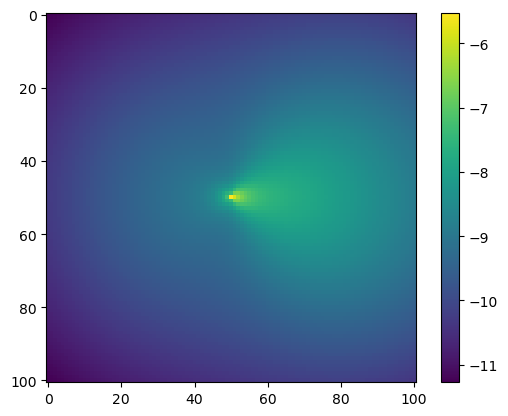

In [373]:
# Create a bearing tensor (e.g., 0 radians) on the desired device
test_bearing = torch.tensor([[0.0]], device=device)

# Instantiate the Params_to_Grid_Block using the given parameters
test_block = Params_to_Grid_Block(params)

# Define the parameters for the movement density
# These are the parameters that the model will learn to predict

# First Gamma distribution
gamma_shape1 = 0.5
gamma_scale1 = 100
gamma_weight1 = 0.25

# Second Gamma distribution
gamma_shape2 = 1.5
gamma_scale2 = 500
gamma_scale2 = gamma_scale2 / 500 # divide this by 500 (as this is what the model predicts)
gamma_weight2 = 0.75

# First von Mises distribution
vonmises_mu1 = 0.0
vonmises_kappa1 = 2.5
vonmises_weight1 = 0.75

# Second von Mises distribution
vonmises_mu2 = -np.pi
vonmises_kappa2 = 0.5
vonmises_weight2 = 0.25

# Provide parameters on a log-scale (since the block exponentiates them internally)
# Here, each group of three values represents a Gamma distribution's shape, scale, and weight, respectively.
movement_density = test_block(
    torch.tensor(
        [[
            # Gamma 1
            np.log(gamma_shape1),   np.log(gamma_scale1),   np.log(gamma_weight1), # Gamma 1 shape, scale, and weight
            # Gamma 2
            np.log(gamma_shape2),   np.log(gamma_scale2),   np.log(gamma_weight2), # Gamma 2 shape, scale, and weight
            # von Mises 1
            vonmises_mu1,           np.log(vonmises_kappa1), np.log(vonmises_weight1), # von Mises 1 mu, kappa, and weight
            # von Mises 2
            vonmises_mu2,           np.log(vonmises_kappa2), np.log(vonmises_weight2) # von Mises 2 mu, kappa, and weight
        ]],
        device=device
    ),
    test_bearing
)

# Alternatively, if you had direct (non-log) values as the model sees them:
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))

# print(movement_density)
print(movement_density.shape)

# Plot the resulting movement density as an image
plt.imshow(movement_density.detach().cpu().numpy()[0])
plt.colorbar()
plt.show()

## Pull out some testing data

To test the other blocks, and the full model, we will need some data. We can pull that out from the training set.

As the test set is shuffled, the `iteration_index` is arbitrary and can be changed to any value between 0 and the number of samples in the test set.

In [409]:
# Number of samples in the test dataset
print("Number of samples in the test dataset: ", len(dataloader_test.dataset))

# Select an index from the test dataset to retrieve a sample, between 0 and number of samples
iteration_index = 9

# 2. Retrieve a single sample (features and label) from the test dataset at the specified index
test_data = x1, x2, x3, labels = dataloader_test.dataset[iteration_index]

# 3. Reshape data tensors to add a batch dimension (since the model expects batches)
x1 = x1.unsqueeze(0).to(device)
x2 = x2.unsqueeze(0).to(device)
x3 = x3.unsqueeze(0).to(device)
labels = labels.unsqueeze(0).to(device)

print(x1.shape, x2.shape, x3.shape, labels.shape)

Number of samples in the test dataset:  1010
torch.Size([1, 4, 101, 101]) torch.Size([1, 4]) torch.Size([1, 1]) torch.Size([1, 101, 101])


### For visualisation, we can return the scale of the covariates to their original values.

In [410]:
# 1. NDVI (Normalized Difference Vegetation Index)
ndvi_norm = x1.detach().cpu()[0, 0, :, :]
ndvi_natural = (ndvi_norm * (ndvi_max - ndvi_min)) + ndvi_min

# 2. Canopy cover
canopy_norm = x1.detach().cpu()[0, 1, :, :]
canopy_natural = (canopy_norm * (canopy_max - canopy_min)) + canopy_min

# 3. Herbaceous vegetation
herby_norm = x1.detach().cpu()[0, 2, :, :]
herby_natural = (herby_norm * (herby_max - herby_min)) + herby_min

# 4. Slope
slope_norm = x1.detach().cpu()[0, 3, :, :]
slope_natural = (slope_norm * (slope_max - slope_min)) + slope_min

### Pull out the scalar values

In [411]:
# Convert the PyTorch tensor x2 to a NumPy array:
#   1) Detach from the computation graph so no gradients are tracked.
#   2) Move to CPU memory.
#   3) Convert to NumPy.
# Then extract the first sample (index 0) and its respective channel for each variable:
hour_t2_sin = x2.detach().cpu().numpy()[0, 0]
hour_t2_cos = x2.detach().cpu().numpy()[0, 1]
yday_t2_sin = x2.detach().cpu().numpy()[0, 2]
yday_t2_cos = x2.detach().cpu().numpy()[0, 3]

# Convert x3 similarly and extract the bearing from the first sample and channel:
bearing = x3.detach().cpu().numpy()[0, 0]

### Helper functions

To return the hour and day of the year to their original values, we can use the following functions.

In [412]:
def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

### Calculate the hour, day of year and previous bearing of the test sample

In [413]:
hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
hour_t2_integer = int(hour_t2)  # Convert to integer
print(f'Hour: {hour_t2_integer}')

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
yday_t2_integer = int(yday_t2)  # Convert to integer
print(f'Day of the year: {yday_t2_integer}')

bearing_degrees = np.degrees(bearing) % 360
bearing_degrees = round(bearing_degrees, 1)  # Round to 2 decimal places
bearing_degrees = int(bearing_degrees)  # Convert to integer
print(f'Bearing (radians): {bearing}')
print(f'Bearing (degrees): {bearing_degrees}')

Hour: 8
Day of the year: 249
Bearing (radians): -0.09606096148490906
Bearing (degrees): 354


### Grab the row and column of the observed next step (label or target)

In [414]:
# Find the coordinates of the element that is 1
target = labels.detach().cpu().numpy()[0,:,:]
coordinates = np.where(target == 1)
# Extract the coordinates
row, column = coordinates[0][0], coordinates[1][0]
print(f"The location of the next step is (row, column): ({row}, {column})")

The location of the next step is (row, column): (60, 80)


### Plot the sample covariates

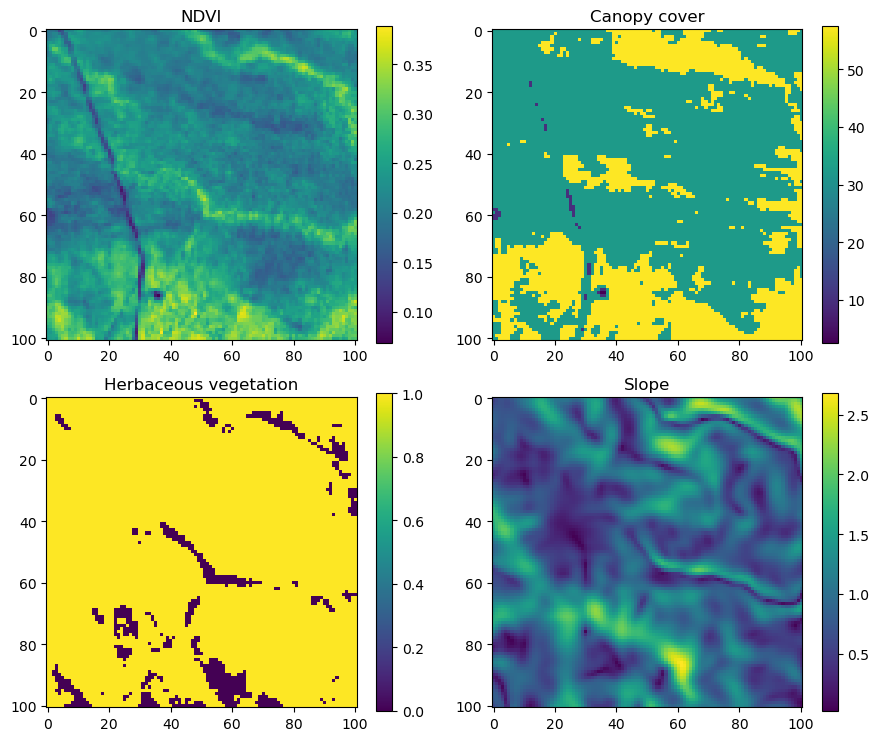

In [415]:
# Plot the covariates
fig, axs = plt.subplots(2, 2, figsize=(9, 7.5))

# Plot NDVI
im1 = axs[0, 0].imshow(ndvi_natural.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI')
fig.colorbar(im1, ax=axs[0, 0])

# Plot Canopy cover
im2 = axs[0, 1].imshow(canopy_natural.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy cover')
fig.colorbar(im2, ax=axs[0, 1])

# Plot Herbaceous vegetation
im3 = axs[1, 0].imshow(herby_natural.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous vegetation')
fig.colorbar(im3, ax=axs[1, 0])

# Plot Slope
im4 = axs[1, 1].imshow(slope_natural.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope')
fig.colorbar(im4, ax=axs[1, 1])

filename_covs = f'outputs/model_training_local/covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
plt.tight_layout()
# plt.savefig(filename_covs, dpi=600, bbox_inches='tight') # if we want to save the figure
plt.show()
plt.close()  # Close the figure to free memory

## Plot the target (location of the next step) 

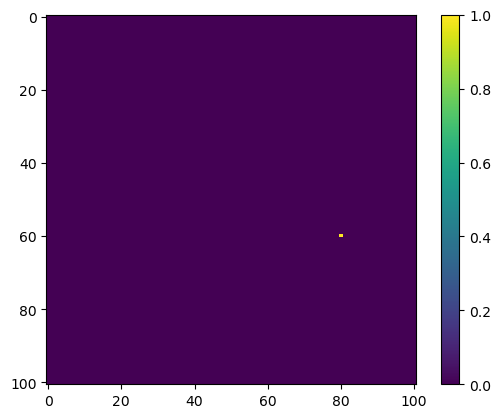

In [416]:
plt.imshow(target)
plt.colorbar()
plt.show()

## Testing the scalar to grid function

This should just create a grid with the same value for all pixels.

torch.Size([1, 4])
tensor([ 0.8660, -0.5000, -0.9164, -0.4002])
torch.Size([1, 4, 101, 101])


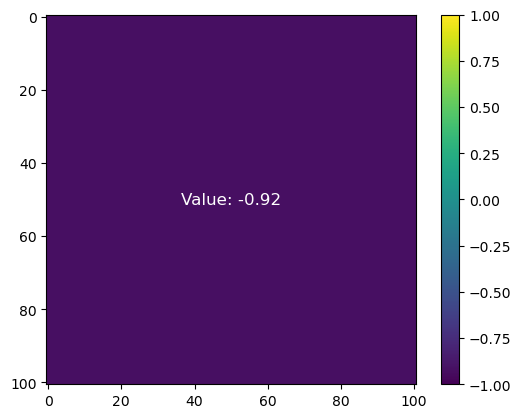

In [417]:
# x2 contains the scalar inputs
print(x2.shape)  # Check the shape of the scalar input
print(x2[0, :])  # Print out the first set of scalars

# Create an instance of the scalar-to-grid block using model parameters
test_block = Scalar_to_Grid_Block(params)

# Convert scalars into spatial grid representation
scalar_maps = test_block(x2)
# print(scalar_maps)  # Optionally, to inspect raw output
print(scalar_maps.shape)  # Check the shape of the generated spatial maps

# Visualize one channel of the first example's scalar map
# (Values are should be repeated across the grid for each scalar)
scalar_index = 2  # Change this index to visualize other scalar maps
plt.imshow(scalar_maps[0, scalar_index]) # change the second index to see the other scalar maps
plt.colorbar()
plt.clim(-1, 1) # Set the color limits to match the range of the scalar values (sine and cosine of temporal parameters)
plt.text(scalar_maps.shape[2] // 2, scalar_maps.shape[3] // 2, 
         f'Value: {round(x2[0, scalar_index].item(), 2)}', 
         ha='center', va='center', color='white', fontsize=12)
plt.show()

# Test the full model

The model is initialised with random weights and hasn't been trained yet, so the output will not be meaningful. However, we can check that the model runs without errors and that the output is the correct shape.

In [418]:
# Put the model in evaluation mode (affects layers like dropout, batch norm, etc.)
model.eval()

# Pass the data through the model
test = model((x1, x2, x3))

# Print the shape of the output
print(test.shape)

torch.Size([1, 101, 101, 2])


## Habitat predictions

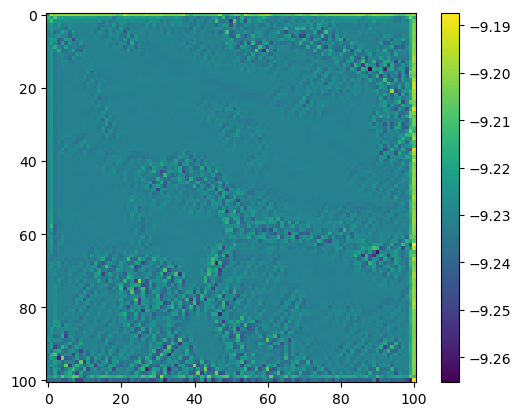

In [420]:
plt.imshow(test.detach().cpu().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

## Movement predictions

Bearing (radians): -0.09606096148490906
Bearing (degrees): 354


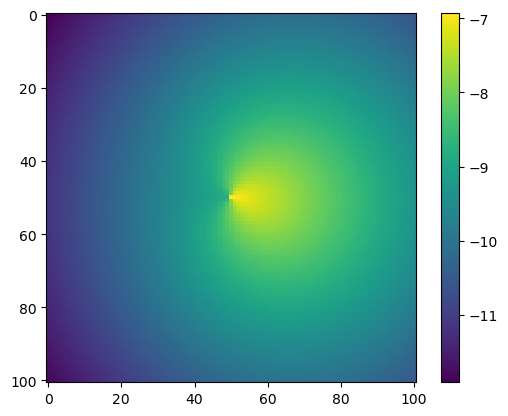

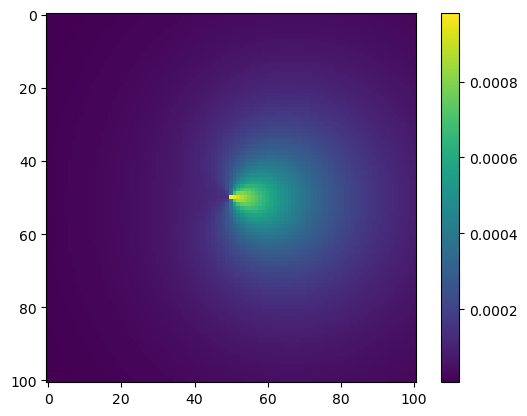

In [421]:
# Print input bearing
print(f'Bearing (radians): {bearing}')
print(f'Bearing (degrees): {bearing_degrees}')

# Plot the movement density on the log-scale
plt.imshow(test.detach().cpu().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

# Plot the movement density on the natural scale
plt.imshow(np.exp(test.detach().cpu().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

## Next-step probability distribution

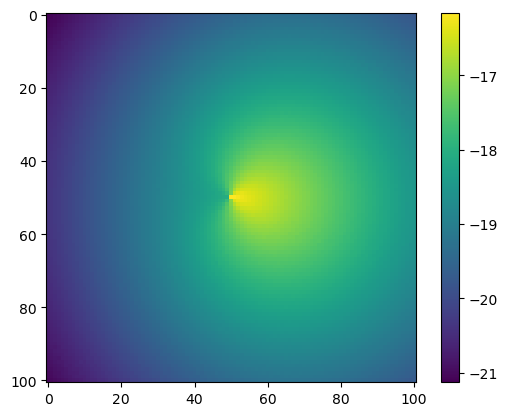

In [422]:
# Combine the habitat selection and the movement probabilities (unnormalised)
next_step = (test[:, :, :, 0] + test[:, :, :, 1])

# Plot the combined output
plt.imshow(next_step.detach().cpu().numpy()[0,:,:])
plt.colorbar()
plt.show()

# Prepare for training

## Loss function

We use a custom negative log likelihood loss function. Essentially what this does is extracts the next-step log-probability at the location of the observed next step, and then takes the negative of this value. This is the loss that we want to minimise, as we want to maximise the probability of the observed next step.

In [387]:
import torch
import torch.nn as nn

class negativeLogLikeLoss(nn.Module):
    """
    Custom negative log-likelihood loss that operates on a 4D prediction tensor 
    (batch, height, width, channels). The forward pass:
    1. Sums across channel 3 (two log-densities, habitat selection and movement predictions) to obtain a combined log-density.
    2. Multiplies this log-density by the target, which is 0 everywhere except for at the location of the next step, effectively extracting that value, 
    then multiplies by -1 such that the function can be minimised (and the probabilities maximised).
    3. Applies the user-specified reduction (mean, sum, or none).
    """

    def __init__(self, reduction='mean'):
        """
        Args:
            reduction (str): Specifies the reduction to apply to the output:
                             'mean', 'sum', or 'none'.
        """
        super(negativeLogLikeLoss, self).__init__()
        assert reduction in ['mean', 'sum', 'none'], \
            "reduction should be 'mean', 'sum', or 'none'"
        self.reduction = reduction

    def forward(self, predict, target):
        """
        Forward pass of the negative log-likelihood loss.

        Args:
            predict (Tensor): A tensor of shape (B, H, W, 2) with log-densities 
                              across two channels to be summed.
            target  (Tensor): A tensor of the same spatial dimensions (B, H, W) 
                              indicating where the log-densities should be evaluated.

        Returns:
            Tensor: The computed negative log-likelihood loss. Shape depends on 
                    the reduction method.
        """
        # Sum the log-densities from the two channels
        predict_prod = predict[:, :, :, 0] + predict[:, :, :, 1]

        # Check for NaNs in the combined predictions
        if torch.isnan(predict_prod).any():
            print("NaNs detected in predict_prod")
            print("predict_prod:", predict_prod)
            raise ValueError("NaNs detected in predict_prod")

        # (Optional) normalization step could go here if needed.
        # The code is commented out because habitat & movement densities
        # are already normalised in their respective blocks

        # Compute negative log-likelihood by multiplying log-densities with target
        # and then flipping the sign
        negLogLike = -1 * (predict_prod * target)

        # Check for NaNs after computing negative log-likelihood
        if torch.isnan(negLogLike).any():
            print("NaNs detected in negLogLike")
            print("negLogLike:", negLogLike)
            raise ValueError("NaNs detected in negLogLike")

        # Apply the specified reduction
        if self.reduction == 'mean':
            return torch.mean(negLogLike)
        elif self.reduction == 'sum':
            return torch.sum(negLogLike)
        elif self.reduction == 'none':
            return negLogLike

        # Default return (though it should never reach here without hitting an if)
        return negLogLike


## Early stopping code

This code will be used to stop training if the validation loss does not improve after a certain number of epochs.

When the loss of the validation data (which is held out from the training data) decreases (i.e. the model improves), the model weights are saved. Each time the validation loss does not decrease, a counter is incremented. If the counter reaches the patience value, the training loop will break and the model will stop training. The 'final' model is then the model that had the lowest validation loss.

In [388]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
    
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        # takes the validation loss and the model as inputs
        score = -val_loss

        # save the model's weights if the validation loss decreases
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        # if the validation loss does not decrease, increment the counter
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Set the learning rate

The learning rate is a hyperparameter that controls how much we are adjusting the weights of our network with respect to the loss gradient. A larger learning rate means that the optimiser will take larger steps, but it may overshoot the minimum. A smaller learning rate means that the optimiser will take smaller steps, but it may take a long time to converge.

We can therefore use an adaptive learning rate, which will adjust the learning rate during training. If the loss does not decrease after a certain number of epochs (also called the patience), the learning rate will be reduced by a factor of 10.

The patience of the learning rate should be less than the patience of the early stopping code, as we want to reduce the learning rate before we stop training.

In [389]:
learning_rate = 1e-3

### Path to save the model weights

In [390]:
path_save_weights = f'model_checkpoints/checkpoint_CNN_buffalo{buffalo_id}_{today_date}.pt'
print(path_save_weights)

model_checkpoints/checkpoint_CNN_buffalo2005_2025-02-02.pt


## Instantiate the loss function, optimiser, learning rate scheduler and early stopping code

In this chunk, we set up all the components needed for training and validating a neural network model:

1. Loss Function: Uses a negative log-likelihood loss (negativeLogLikeLoss) with mean reduction.
2. Optimizer: Implements the Adam optimization algorithm, updating model parameters based on the computed gradients and a specified learning rate.
3. Scheduler: Automatically reduces the learning rate when the monitored metric (e.g., validation loss) stops improving.
4. Early Stopping: Monitors validation performance and stops training if the metric fails to improve after a certain number of epochs (patience).

In [391]:
# 1. Define the negative log-likelihood loss function with mean reduction
loss_fn = negativeLogLikeLoss(reduction='mean')

# 2. Set up the Adam optimizer for updating the model's parameters
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# 3. Create a learning rate scheduler that reduces the LR by a factor of 0.1 
#    if validation loss has not improved for 'patience=5' epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser,  # The optimizer whose learning rate will be adjusted
    mode='min', # The metric to be minimized (e.g., validation loss)
    factor=0.1, # Factor by which the learning rate will be reduced
    patience=5  # Number of epochs with no improvement before learning rate reduces
)

# 4. EarlyStopping stops training after 'patience=10' epochs with no improvement, 
#    optionally saving the best model weights
early_stopping = EarlyStopping(patience=10, verbose=True, path=path_save_weights)

## Training loop

This code defines the main training loop for a single epoch. It iterates over batches from the training dataloader, moves the data to the correct device (e.g., CPU or GPU), calculates the loss, and performs backpropagation to update the model parameters. It also prints periodic updates of the current loss.

In [392]:
def train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler, iteration_index):
    """
    Runs the training process for one epoch using the given dataloader, model, 
    loss function, and optimizer. Prints progress updates every few batches.
    """

    # 1. Total number of training examples
    size = len(dataloader_train.dataset)

    # 2. Put model in training mode (affects layers like dropout, batchnorm)
    model.train()

    # 3. Variable to accumulate the total loss over the epoch
    epoch_loss = 0.0

    # 4. Loop over batches in the training dataloader
    for batch, (x1, x2, x3, y) in enumerate(dataloader_train):

        # Move the batch of data to the specified device (CPU/GPU)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        y = y.to(device)

        # Forward pass: compute the model output and loss
        loss = loss_fn(model((x1, x2, x3)), y)
        epoch_loss += loss

        # Backpropagation: compute gradients and update parameters
        loss.backward()
        optimiser.step()

        # Reset gradients before the next iteration
        optimiser.zero_grad()

        # Print an update every 5 batches to keep track of training progress
        if batch % 5 == 0:
            loss_val = loss.item()
            current = batch * bs + len(x1)
            print(f"loss: {loss_val:>15f}  [{current:>5d}/{size:>5d}]")


## Test loop

The test loop is similar to the training loop, but it does not perform backpropagation. It calculates the loss on the test set and returns the average loss.

In [393]:
def test_loop(dataloader_test, model, loss_fn):
    """
    Evaluates the model on the provided test dataset by computing 
    the average loss over all batches. 
    No gradients are computed during this process (torch.no_grad()).
    """

    # 1. Set the model to evaluation mode (affects layers like dropout, batchnorm).
    model.eval()

    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    
    test_loss = 0

    # 2. Disable gradient computation to speed up evaluation and reduce memory usage
    with torch.no_grad():
        # 3. Loop through each batch in the test dataloader
        for x1, x2, x3, y in dataloader_test:

            # Move the batch of data to the appropriate device (CPU/GPU)
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            # Compute the loss on the test set (no backward pass needed)
            test_loss += loss_fn(model((x1, x2, x3)), y)

    # 4. Compute average test loss over all batches
    test_loss /= num_batches

    # Print the average test loss
    print(f"Avg test loss: {test_loss:>15f} \n")


# Train the model

Here we have the main training process that loops over multiple epochs. Each epoch involves:

1. Training the model on a training dataset.
2. Validating the model on a validation dataset to monitor its performance and adjust the learning rate (via scheduler).
3. Checking for early stopping conditions. If triggered, the best model weights are restored, and a test evaluation is performed.

Additionally, commented-out code at the end shows how you might visualise and save intermediate training results (such as predicted probability surfaces) for diagnostic or research purposes. The saved images can then be combined into an animation.

In [111]:
epochs = 100
val_losses = []   # Track validation losses across epochs

for t in range(epochs):
    val_loss = 0.0
    num_batches = len(dataloader_test)

    print(f"Epoch {t+1}\n-------------------------------")

    # 1. Run the training loop for one epoch using the training dataloader
    train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler, iteration_index)

    # 2. Evaluate model performance on the validation dataset
    model.eval()  # Switch to evaluation mode for proper layer behavior
    with torch.no_grad():
        
        for x1, x2, x3, y in dataloader_val:
            # Move data to the chosen device (CPU/GPU)
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            # Accumulate validation loss
            val_loss += loss_fn(model((x1, x2, x3)), y)

    # 3. Step the scheduler based on the validation loss (adjusts learning rate if needed)
    scheduler.step(val_loss)

    # 4. Compute the average validation loss and print it, along with the current learning rate
    val_loss /= num_batches
    print(f"\nAvg validation loss: {val_loss:>15f}")
    print(f"Learning rate: {scheduler.get_last_lr()}")

    # 5. Track the validation loss for plotting or monitoring
    val_losses.append(val_loss)

    # 6. Early stopping: if no improvement in validation loss for a set patience, stop training
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        # Restore the best model weights saved by EarlyStopping
        model.load_state_dict(torch.load(path_save_weights, weights_only=True))
        test_loop(dataloader_test, model, loss_fn)  # Evaluate on test set once training stops
        break
    else:
        model.eval()
        print("\n")


    # # ----------------------------------------------------
    # # The following code demonstrates how 
    # # to optionally visualize or save intermediate results 
    # # (e.g., habitat probability surface, movement probability,
    # # and next-step probability surfaces).

    # # uncomment the code all in one go to run it (it should be inside the training loop)
    # # ----------------------------------------------------

    # # -----------------------------------------------------------
    # # 1. Retrieve a single test example (covariates and labels) 
    # #    at the specified 'iteration_index' from the test dataset
    # # -----------------------------------------------------------
    # x1, x2, x3, labels = dataloader_test.dataset[iteration_index]

    # # -----------------------------------------------------------
    # # 2. Add a batch dimension and move tensors to the device 
    # #    for model inference
    # # -----------------------------------------------------------
    # x1 = x1.unsqueeze(0).to(device)
    # x2 = x2.unsqueeze(0).to(device)
    # x3 = x3.unsqueeze(0).to(device)

    # # -----------------------------------------------------------
    # # 3. Run the model on the single test example
    # # -----------------------------------------------------------
    # test = model((x1, x2, x3))

    # # -----------------------------------------------------------
    # # 4. Extract habitat and movement outputs; 
    # #    convert them to NumPy arrays for visualization
    # # -----------------------------------------------------------
    # hab_density = test.detach().cpu().numpy()[0, :, :, 0]
    # movement_density = test.detach().cpu().numpy()[0, :, :, 1]

    # # -----------------------------------------------------------
    # # 5. Generate masks to exclude certain border cells for 
    # #    color scale reasons (setting them to -inf).
    # # -----------------------------------------------------------
    # x_mask = np.ones_like(hab_density)
    # y_mask = np.ones_like(hab_density)

    # # Mask out a few columns (0-2 and 98-end) and rows (0-2 and 98-end)
    # x_mask[:, :3] = -np.inf
    # x_mask[:, 98:] = -np.inf
    # y_mask[:3, :] = -np.inf
    # y_mask[98:, :] = -np.inf

    # # Apply the masks to habitat density
    # hab_density_mask = hab_density * x_mask * y_mask

    # # Combine habitat and movement densities to represent 
    # # next-step probability
    # step_density = hab_density + movement_density
    # step_density_mask = step_density * x_mask * y_mask

    # # -----------------------------------------------------------
    # # 6. Plot and save the habitat probability surface
    # # -----------------------------------------------------------
    # filename_hab = f'outputs/model_training_local/hab_log_prob_covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_{today_date}_epoch{t}.png'
    # plt.figure()
    # plt.imshow(hab_density_mask)
    # plt.colorbar()
    # plt.draw()  # Render the plot before saving
    # plt.savefig(filename_hab, dpi=600, bbox_inches='tight')
    # plt.close()  # Close the figure to free memory

    # # -----------------------------------------------------------
    # # 7. Plot and save the movement probability surface
    # # -----------------------------------------------------------
    # filename_move = f'outputs/model_training_local/move_log_prob_covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_{today_date}_epoch{t}.png'
    # plt.figure()
    # plt.imshow(movement_density)
    # plt.colorbar()
    # plt.draw()
    # plt.savefig(filename_move, dpi=600, bbox_inches='tight')
    # plt.close()

    # # -----------------------------------------------------------
    # # 8. Plot and save the combined (next-step) probability surface
    # # -----------------------------------------------------------
    # filename_step = f'outputs/model_training_local/step_log_prob_covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_{today_date}_epoch{t}.png'
    # plt.figure()
    # plt.imshow(step_density_mask)
    # plt.colorbar()
    # plt.draw()
    # plt.savefig(filename_step, dpi=600, bbox_inches='tight')
    # plt.close()

print("Done!")

Epoch 1
-------------------------------
loss:        0.000824  [   32/ 8083]
loss:        0.000785  [  192/ 8083]
loss:        0.000786  [  352/ 8083]
loss:        0.000722  [  512/ 8083]
loss:        0.000714  [  672/ 8083]
loss:        0.000688  [  832/ 8083]
loss:        0.000655  [  992/ 8083]
loss:        0.000651  [ 1152/ 8083]
loss:        0.000672  [ 1312/ 8083]
loss:        0.000654  [ 1472/ 8083]
loss:        0.000647  [ 1632/ 8083]
loss:        0.000599  [ 1792/ 8083]
loss:        0.000590  [ 1952/ 8083]
loss:        0.000640  [ 2112/ 8083]
loss:        0.000693  [ 2272/ 8083]
loss:        0.000646  [ 2432/ 8083]
loss:        0.000632  [ 2592/ 8083]
loss:        0.000650  [ 2752/ 8083]
loss:        0.000596  [ 2912/ 8083]
loss:        0.000582  [ 3072/ 8083]
loss:        0.000623  [ 3232/ 8083]
loss:        0.000623  [ 3392/ 8083]
loss:        0.000582  [ 3552/ 8083]
loss:        0.000580  [ 3712/ 8083]
loss:        0.000535  [ 3872/ 8083]
loss:        0.000524  [ 4032/ 8083

C:\Users\for329\AppData\Local\Temp\ipykernel_3612\1463126803.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_save_weights))


Avg test loss:        0.000502 

Done!


In [113]:
# to look at the parameters (weights and biases) of the model
# print(model.state_dict())

# Loading in previous models

As we've trained the model, the model parameters are already stored in the `model` object. But as we were training the model, we were saving it to file, and that, and other trained models can be loaded. 

The model parameters that are being loaded must match the model object that has been defined above. If the model object has changed, the model parameters will not be able to be loaded.

In [423]:
path_save_weights

'model_checkpoints/checkpoint_CNN_buffalo2005_2025-02-02.pt'

In [424]:
# to load previously saved weights
path_save_weights = f'model_checkpoints/checkpoint_CNN_buffalo2005_2025-01-30.pt'

model.load_state_dict(torch.load(path_save_weights, 
                                 weights_only=True,
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

# View model outputs

### Validation loss

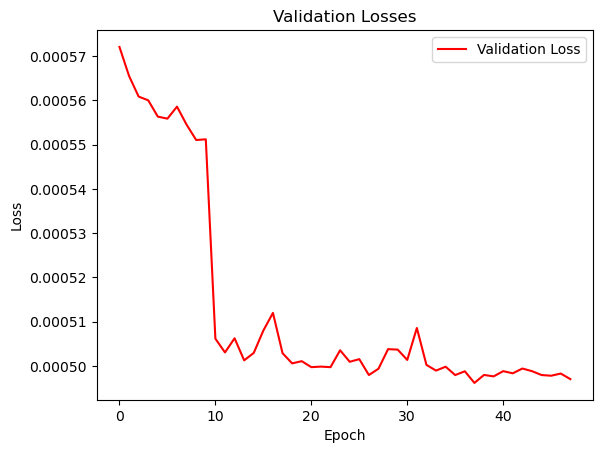

In [450]:
filename_loss = f'outputs/model_training_local/val_loss_buffalo{buffalo_id}_{today_date}.png'
plt.plot(val_losses, label='Validation Loss', color='red')  # Plot validation loss in red
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Show legend to distinguish lines
plt.savefig(filename_loss, dpi=600, bbox_inches='tight')
plt.show()


## Test the model on sample covariates

Use the same sample covariates as above (selected before training the model) from the *test* dataset, and then run the model on these covariates. To select a different sample, change the `iteration_index` in the code above and re-run those chunks.

Print the scalar values and plot the sample covariates

Hour: 8
Day of the year: 249
Bearing (radians): -0.09606096148490906
Bearing (degrees): 354


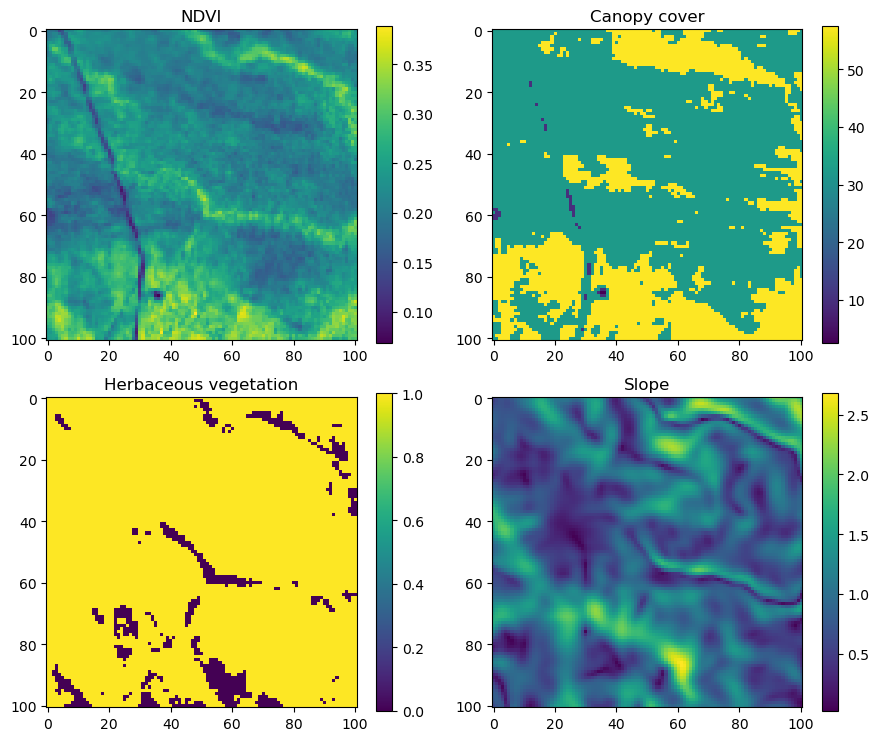

In [426]:
# To save the outputs of the model, create a directory
output_dir = f'outputs/model_outputs/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}'
os.makedirs(output_dir, exist_ok=True)

# Print relevant information about the current prediction context
# such as time of day, day of year, and bearing angles in both radians and degrees.
print(f'Hour: {hour_t2_integer}')
print(f'Day of the year: {yday_t2_integer}')
print(f'Bearing (radians): {bearing}')
print(f'Bearing (degrees): {bearing_degrees}')

# Plot the covariates
fig, axs = plt.subplots(2, 2, figsize=(9, 7.5))

# Plot NDVI
im1 = axs[0, 0].imshow(ndvi_natural.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI')
fig.colorbar(im1, ax=axs[0, 0])

# Plot Canopy cover
im2 = axs[0, 1].imshow(canopy_natural.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy cover')
fig.colorbar(im2, ax=axs[0, 1])

# Plot Herbaceous vegetation
im3 = axs[1, 0].imshow(herby_natural.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous vegetation')
fig.colorbar(im3, ax=axs[1, 0])

# Plot Slope
im4 = axs[1, 1].imshow(slope_natural.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope')
fig.colorbar(im4, ax=axs[1, 1])

filename_covs = f'{output_dir}/id{buffalo_id}_sample{iteration_index}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
plt.tight_layout()
plt.savefig(filename_covs, dpi=600, bbox_inches='tight') # if we want to save the figure
plt.show()
plt.close()  # Close the figure to free memory

## Run the model on the sample covariates

torch.Size([1, 101, 101, 2])


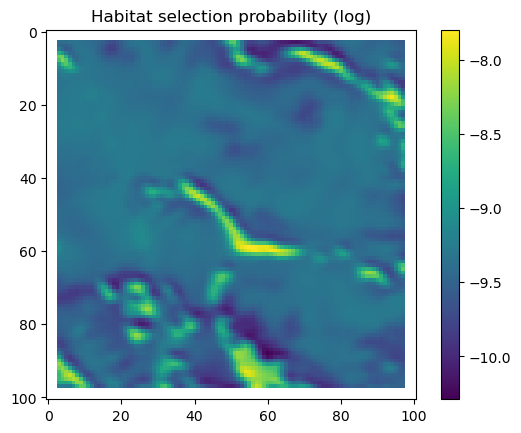

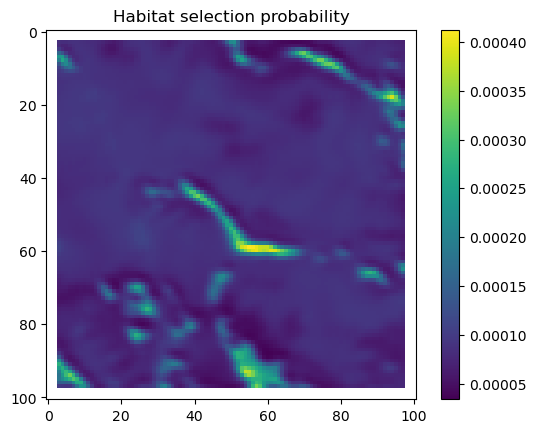

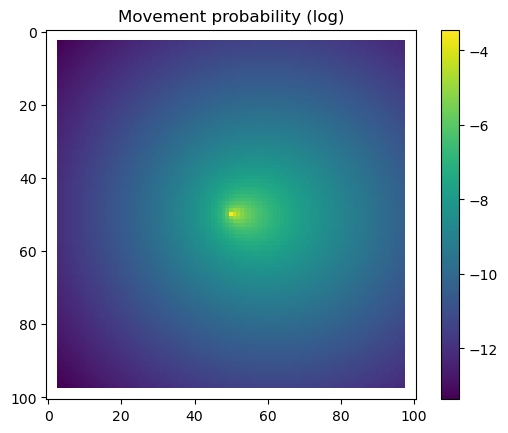

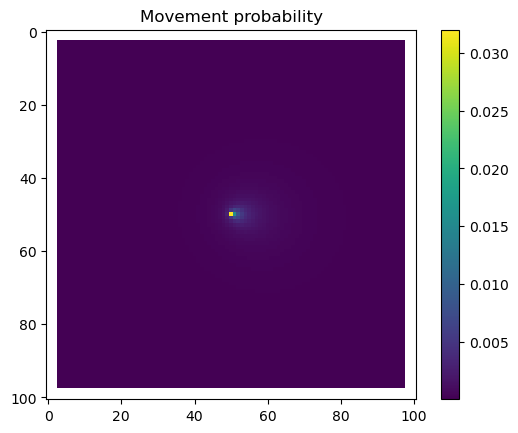

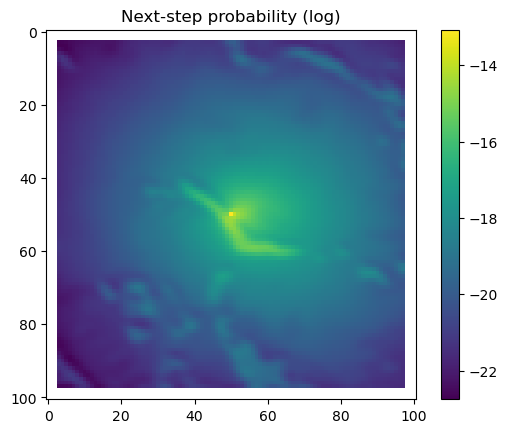

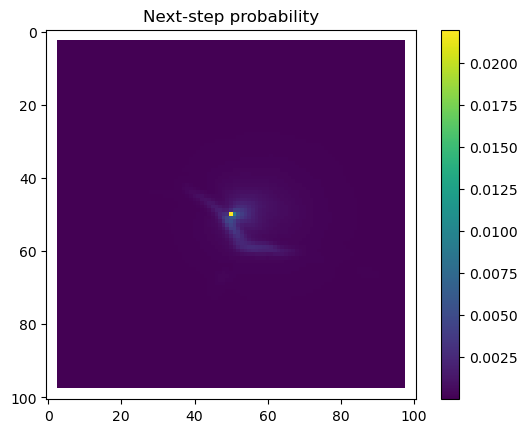

In [427]:
# -------------------------------------------------------------------------
# 1. Switch the model to evaluation mode (e.g., disables dropout, etc.)
# -------------------------------------------------------------------------
model.eval()

# -------------------------------------------------------------------------
# 2. Move all input tensors (x1, x2, x3) to the appropriate device (CPU/GPU)
# -------------------------------------------------------------------------
x1 = x1.to(device)
x2 = x2.to(device)
x3 = x3.to(device)

# -------------------------------------------------------------------------
# 3. Pass the inputs through the model; 'test' will have shape [batch, H, W, 2]
# -------------------------------------------------------------------------
test = model((x1, x2, x3))
print(test.shape)

# -------------------------------------------------------------------------
# 4. Extract and exponentiate the habitat density channel
#    (at index 0 in the last dimension)
# -------------------------------------------------------------------------
hab_density = test.detach().cpu().numpy()[0, :, :, 0]
hab_density_exp = np.exp(hab_density)
# print(np.sum(hab_density_exp))  # Debug: check the sum of exponentiated values

# -------------------------------------------------------------------------
# 5. Create masks to remove unwanted edge cells from visualization
#    (setting them to -∞ affects the color scale in plots)
# -------------------------------------------------------------------------
x_mask = np.ones_like(hab_density)
y_mask = np.ones_like(hab_density)

x_mask[:, :3] = -np.inf
x_mask[:, 98:] = -np.inf
y_mask[:3, :] = -np.inf
y_mask[98:, :] = -np.inf

# -------------------------------------------------------------------------
# 6. Apply the masks to the habitat density (log scale) and exponentiated version
# -------------------------------------------------------------------------
hab_density_mask = hab_density * x_mask * y_mask
hab_density_exp_mask = hab_density_exp * x_mask * y_mask

# -------------------------------------------------------------------------
# 7. Plot and save the habitat density in log scale
# -------------------------------------------------------------------------
plt.imshow(hab_density_mask)
plt.colorbar()
plt.title('Habitat selection probability (log)')
plt.savefig(f'{output_dir}/hab_log_prob_id{buffalo_id}_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# -------------------------------------------------------------------------
# 8. Plot and save the habitat density in probability (exponentiated) scale
# -------------------------------------------------------------------------
plt.imshow(hab_density_exp_mask)
plt.colorbar()
plt.title('Habitat selection probability')
plt.savefig(f'{output_dir}/hab_prob_id{buffalo_id}_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# -------------------------------------------------------------------------
# 9. Extract and exponentiate the movement density channel
#    (at index 1 in the last dimension)
# -------------------------------------------------------------------------
move_density = test.detach().cpu().numpy()[0, :, :, 1]
move_density_exp = np.exp(move_density)
# print(np.sum(move_density_exp))  # Debug: check the sum of exponentiated values

# -------------------------------------------------------------------------
# 10. Apply the same masking strategy to movement densities
# -------------------------------------------------------------------------
move_density_mask = move_density * x_mask * y_mask
move_density_exp_mask = move_density_exp * x_mask * y_mask

# -------------------------------------------------------------------------
# 11. Plot and save the movement density in log scale
# -------------------------------------------------------------------------
plt.imshow(move_density_mask)
plt.colorbar()
plt.title('Movement probability (log)')
plt.savefig(f'{output_dir}/move_log_prob_id{buffalo_id}_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# -------------------------------------------------------------------------
# 12. Plot and save the movement density in probability (exponentiated) scale
# -------------------------------------------------------------------------
plt.imshow(move_density_exp_mask)
plt.colorbar()
plt.title('Movement probability')
plt.savefig(f'{output_dir}/move_prob_id{buffalo_id}_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# -------------------------------------------------------------------------
# 13. Compute the next-step density by adding habitat + movement (log-space)
#     Then exponentiate and normalize
# -------------------------------------------------------------------------
step_density = test[0, :, :, 0] + test[0, :, :, 1]
step_density = step_density.detach().cpu().numpy()
step_density_exp = np.exp(step_density)
# print('Sum of step density exp = ', np.sum(step_density_exp))  # Debug

step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
# print('Sum of step density exp norm = ', np.sum(step_density_exp_norm))  # Debug

# -------------------------------------------------------------------------
# 14. Apply masks to the step densities (log and exponentiated + normalized)
# -------------------------------------------------------------------------
step_density_mask = step_density * x_mask * y_mask
step_density_exp_norm_mask = step_density_exp_norm * x_mask * y_mask

# -------------------------------------------------------------------------
# 15. Plot and save the combined next-step probability surface in log scale
# -------------------------------------------------------------------------
plt.imshow(step_density_mask)
plt.colorbar()
plt.title('Next-step probability (log)')
plt.savefig(f'{output_dir}/step_log_prob_id{buffalo_id}_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# -------------------------------------------------------------------------
# 16. Plot and save the combined next-step probability surface in probability scale
# -------------------------------------------------------------------------
plt.imshow(step_density_exp_norm_mask)
plt.colorbar()
plt.title('Next-step probability')
plt.savefig(f'{output_dir}/step_prob_id{buffalo_id}_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()


# Extracting convolution layer outputs

In the convolutional blocks, each convolutional layer learns a set of **filters** (kernels) that extract different features from the input data. In the habitat selection subnetwork, the convolution filters (and their associated bias parameters - not shown below) are the only parameters that are trained, and it is the filters that transform the set of input covariates into the habitat selection probabilities. They do this by maximising features of the inputs that correlate with observed next-steps.

For each convolutional layer, there are typically a number of filters. For the habitat selection subnetwork, we used 4 filters in the first two layers, and a single filter in the last layer. Each of these filters has a number of **channels** which correspond one-to-one with the input layers. The outputs of the filter channels are then combined to produce a feature map, with a single feature map produced for each filter. In successive layers, the feature maps become the input layers, and the filters operate on these layers. Because there are multiple filters in ech layer, they can 'specialise' in extracting different features from the input layers.

By visualizing and inspecting these filters, and the corresponding feature maps, we can:

- Gain interpretability: Understand what kind of features the network is detecting—e.g., edges, shapes, or textures.
- Debug: Check if the filters have meaningful patterns or if something went wrong (e.g., all zeros or random noise).
- Compare layers: See how early layers often learn low-level patterns while deeper layers learn more abstract features.

We will first set up some activation hooks for storing the feature maps. Activation hooks are placed at certain points within the model's forward pass and store intermediate results. We will also extract the convolution filters (which are weights of the model and as such don't require hooks - we can access them directly).

We will then run the sample covariates through the model and extract the feature maps from the habitat selection convolutional block, and plot them along with the covariates and convolution filters.

Note that there are also ReLU activation functions in the convolutional blocks, which are not shown below. These are applied to the feature maps, and set all negative values to zero. They are not learned parameters, but are part of the forward pass of the model.


## Convolutional layer 1

### Activation hook

In [428]:
# -----------------------------------------------------------
# Create a dictionary to store activation outputs
# -----------------------------------------------------------
activation = {}

def get_activation(name):
    """
    Returns a hook function that can be registered on a layer 
    to capture its output (i.e., feature maps) after the forward pass.

    Args:
        name (str): The key under which the activation is stored in the 'activation' dict.
    """
    def hook(model, input, output):
        # Detach and save the layer's output in the dictionary
        activation[name] = output.detach()
    return hook

# -----------------------------------------------------------
# Register a forward hook on the first convolution layer 
#    in the model's 'conv_habitat' block
# -----------------------------------------------------------
model.conv_habitat.conv2d[0].register_forward_hook(get_activation("hab_conv1"))

# -----------------------------------------------------------
# Perform a forward pass through the model with the desired input
#    The feature maps from the hooked layer will be stored in 'activation'
# -----------------------------------------------------------
out = model((x1, x2, x3))  # e.g., model((spatial_data_x, scalars_to_grid, bearing_x))

# -----------------------------------------------------------
# Retrieve the captured feature maps from the dictionary
#    and move them to the CPU for inspection
# -----------------------------------------------------------
feat_maps1 = activation["hab_conv1"].cpu()
print("Feature map shape:", feat_maps1.shape)
# Typically shape: (batch_size, out_channels, height, width)

# -----------------------------------------------------------
# Visualize the feature maps for the first sample in the batch
# -----------------------------------------------------------
feat_maps1_sample = feat_maps1[0]  # Shape: (out_channels, H, W)
num_maps1 = feat_maps1_sample.shape[0]
print("Number of feature maps:", num_maps1)



Feature map shape: torch.Size([1, 4, 101, 101])
Number of feature maps: 4


### Stack spatial and scalar (as grid) covariates

For plotting. Also create a vector of names to index over.

In [429]:
covariate_stack = torch.cat([x1, scalar_maps], dim=1)
print(covariate_stack.shape)

covariate_names = ['NDVI', 'Canopy cover', 'Herbaceous vegetation', 'Slope', 
                   'Hour sin', 'Hour cos', 'yday sin', 'yday cos']

torch.Size([1, 8, 101, 101])


### Extract filters and plot

Sequential(
  (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Filters shape: torch.Size([4, 8, 3, 3])
8


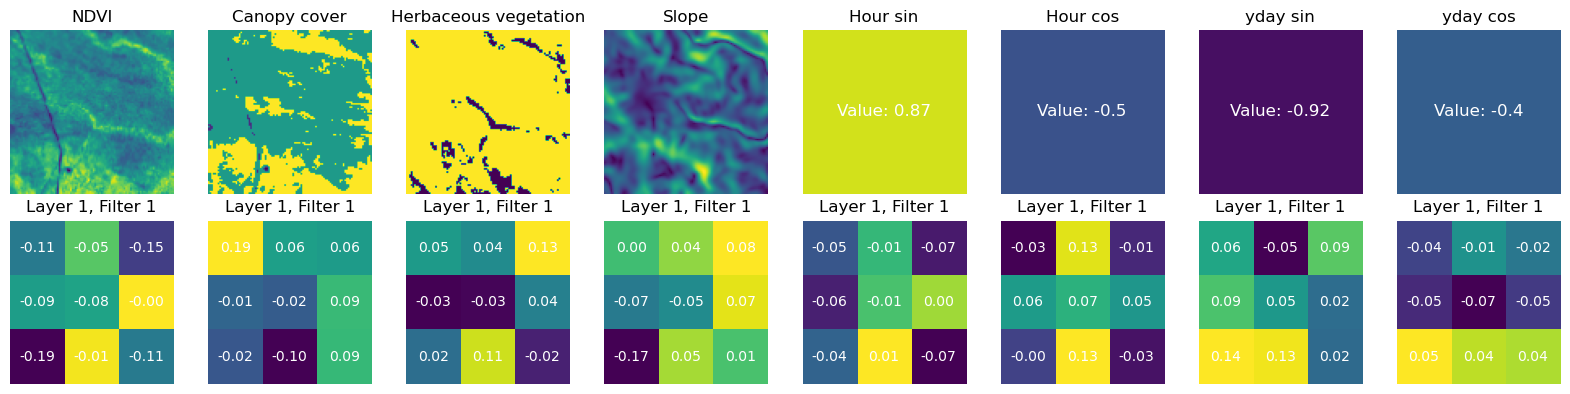

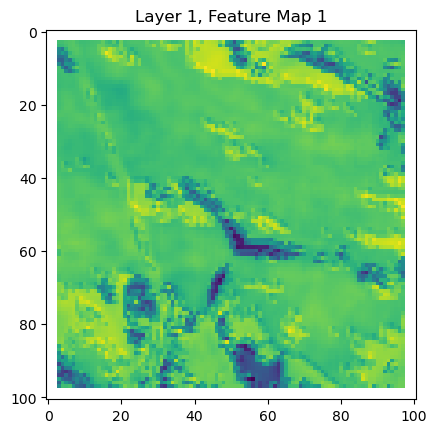

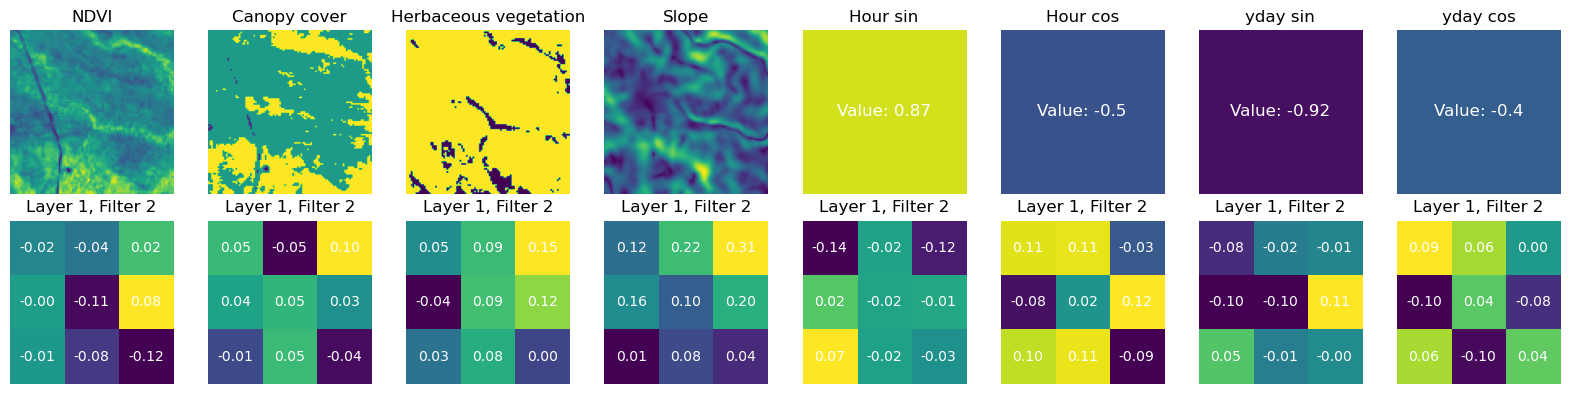

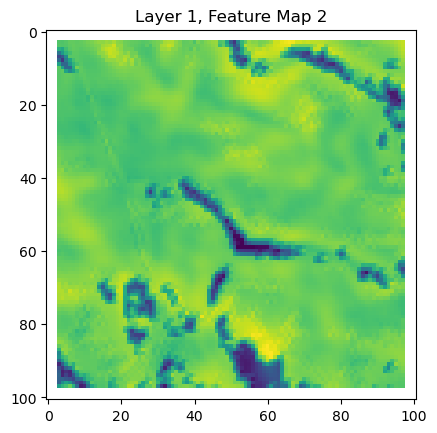

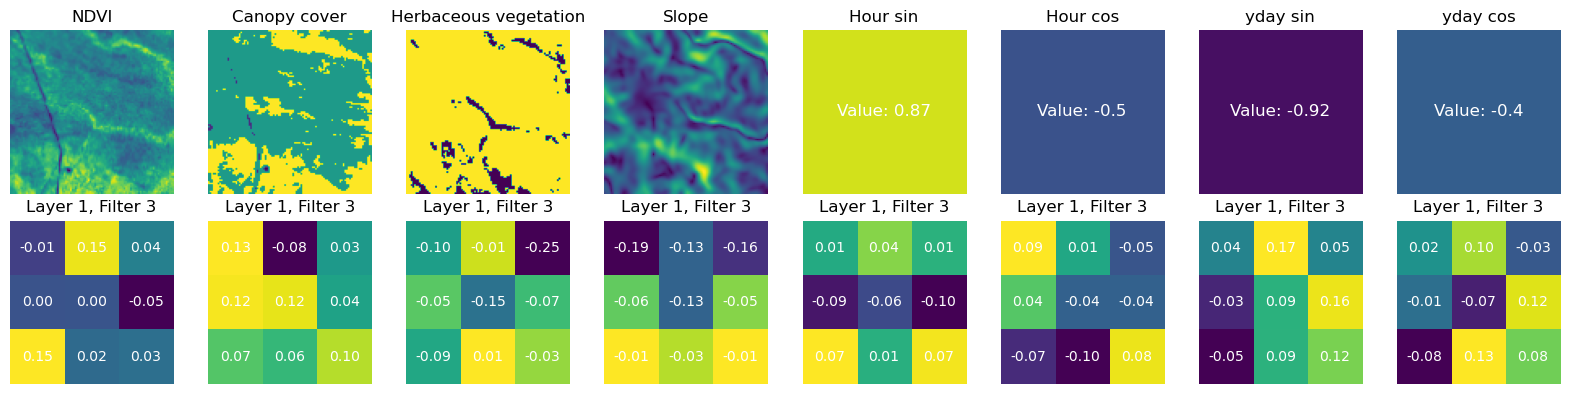

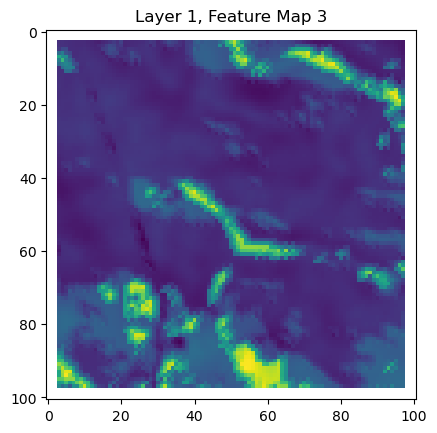

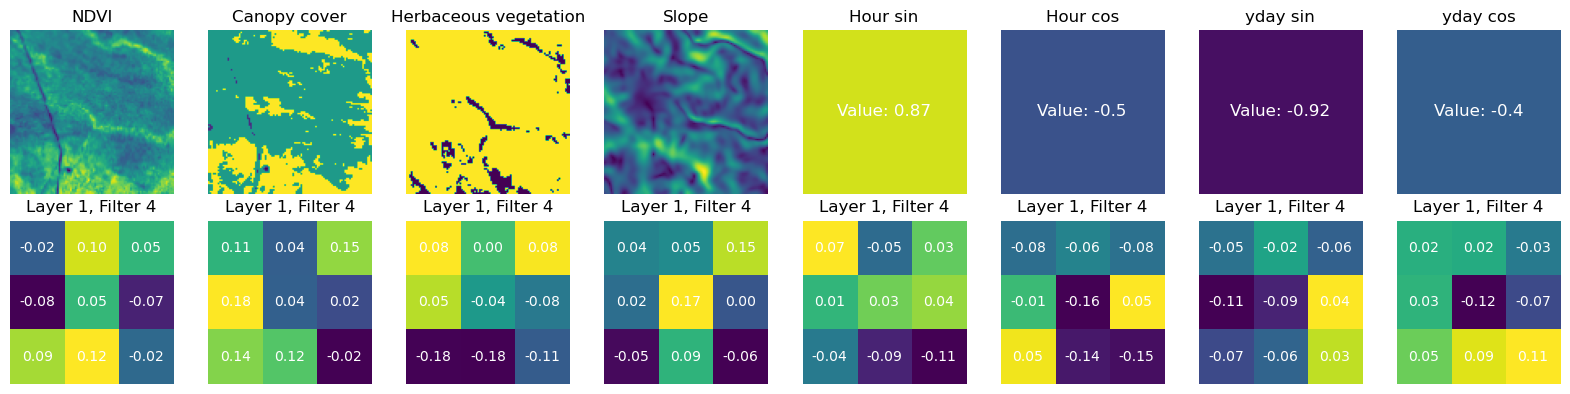

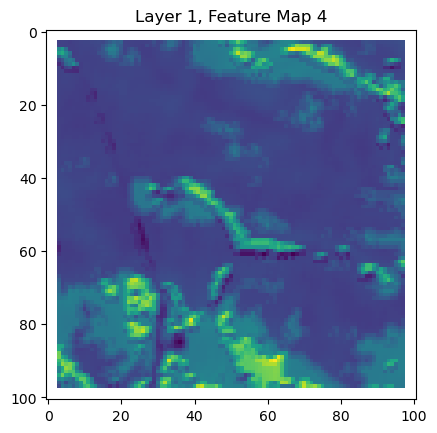

In [430]:
# -------------------------------------------------------------------------
# Check or print the convolution layer in conv_habitat (for debugging)
# -------------------------------------------------------------------------
print(model.conv_habitat.conv2d)

# -------------------------------------------------------------------------
# Set the model to evaluation mode (disables dropout, etc.)
# -------------------------------------------------------------------------
model.eval()

# -------------------------------------------------------------------------
# Extract the weights (filters) from the first convolution layer in conv_habitat
# -------------------------------------------------------------------------
filters_c1 = model.conv_habitat.conv2d[0].weight.data.clone().cpu()
print("Filters shape:", filters_c1.shape)
# Typically (out_channels, in_channels, kernel_height, kernel_width)

# -------------------------------------------------------------------------
# Visualize each filter’s first channel in a grid of subplots
# -------------------------------------------------------------------------
num_filters_c1 = filters_c1.shape[1]
print(num_filters_c1)

for z in range(num_maps1):

    fig, axes = plt.subplots(2, num_filters_c1, figsize=(2*num_filters_c1, 4))
    for i in range(num_filters_c1):

        # Add the covariates as the first row of subplots
        axes[0,i].imshow(covariate_stack[0, i].detach().cpu().numpy(), cmap='viridis')
        axes[0,i].axis('off')
        axes[0,i].set_title(f'{covariate_names[i]}')
        if i > 3:
            im1 = axes[0,i].imshow(covariate_stack[0, i].detach().cpu().numpy(), cmap='viridis')
            im1.set_clim(-1, 1)
            axes[0,i].text(scalar_maps.shape[2] // 2, scalar_maps.shape[3] // 2, 
                f'Value: {round(x2[0, i-4].item(), 2)}', 
                ha='center', va='center', color='white', fontsize=12)

        kernel = filters_c1[z, i, :, :]  # Show the first input channel
        im = axes[1,i].imshow(kernel, cmap='viridis')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Layer 1, Filter {z+1}')
        # Annotate each cell with the numeric value
        for (j, k), val in np.ndenumerate(kernel):
            axes[1,i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer1_filters{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()

        
    # -----------------------------------------------------------
    # Loop over each feature map channel and save them as images.
    #    Multiply by x_mask * y_mask if you need to mask out edges.
    # -----------------------------------------------------------

    plt.figure()
    plt.imshow(feat_maps1_sample[z].numpy() * x_mask * y_mask, cmap='viridis')
    plt.title(f"Layer 1, Feature Map {z+1}")
    # Hide axis if you prefer: plt.axis('off')
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer1_feature_map{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()



## Convolutional layer 2

### Activation hook

In [440]:
# -----------------------------------------------------------
# Register a forward hook on the second convolution layer 
#    in the model's 'conv_habitat' block
# -----------------------------------------------------------
model.conv_habitat.conv2d[2].register_forward_hook(get_activation("hab_conv2"))

# -----------------------------------------------------------
# Perform a forward pass through the model with the desired input
#    The feature maps from the hooked layer will be stored in 'activation'
# -----------------------------------------------------------
out = model((x1, x2, x3))  # e.g., model((spatial_data_x, scalars_to_grid, bearing_x))

# -----------------------------------------------------------
# Retrieve the captured feature maps from the dictionary
#    and move them to the CPU for inspection
# -----------------------------------------------------------
feat_maps2 = activation["hab_conv2"].cpu()
print("Feature map shape:", feat_maps2.shape)
# Typically shape: (batch_size, out_channels, height, width)

# -----------------------------------------------------------
# Visualize the feature maps for the first sample in the batch
# -----------------------------------------------------------
feat_maps2_sample = feat_maps2[0]  # Shape: (out_channels, H, W)
num_maps2 = feat_maps2_sample.shape[0]
print("Number of feature maps:", num_maps2)



Feature map shape: torch.Size([1, 4, 101, 101])
Number of feature maps: 4


### Extract filters and plot

Filters shape: torch.Size([4, 4, 3, 3])
4


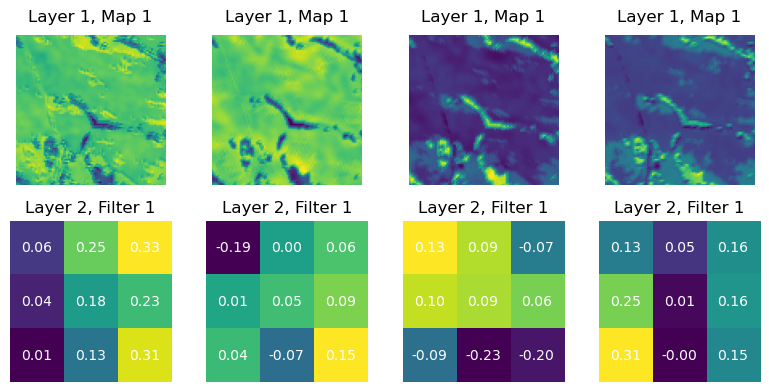

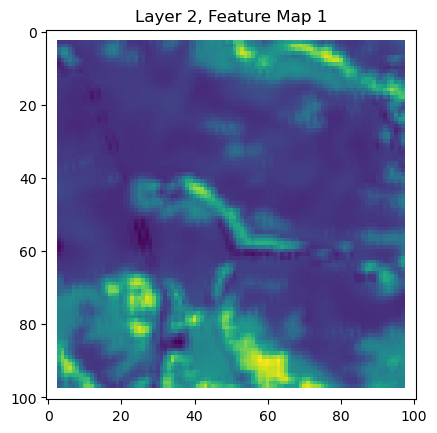

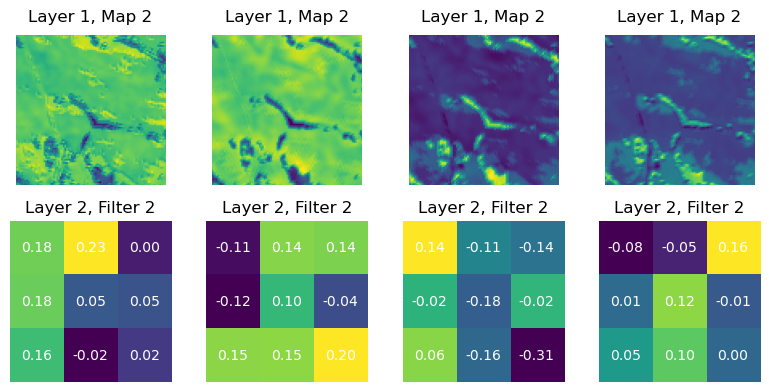

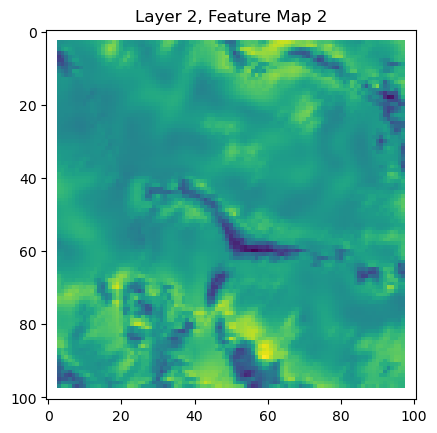

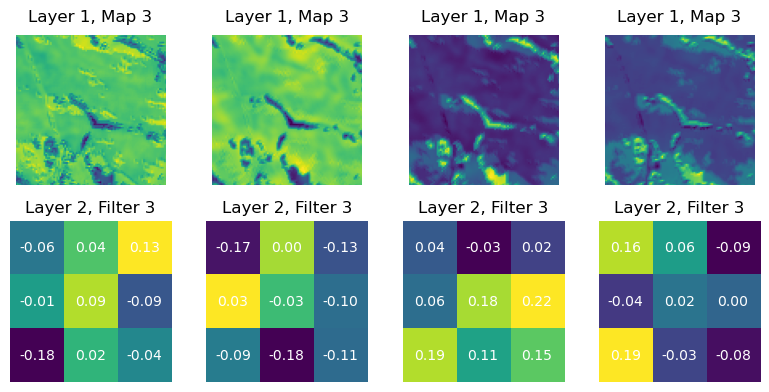

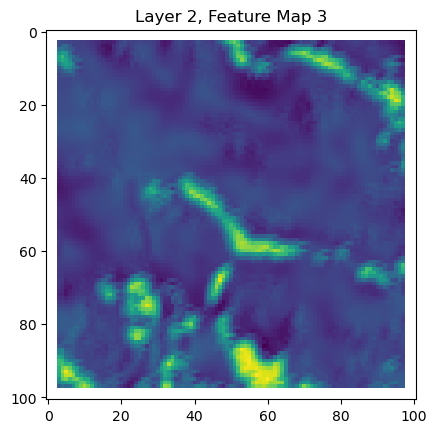

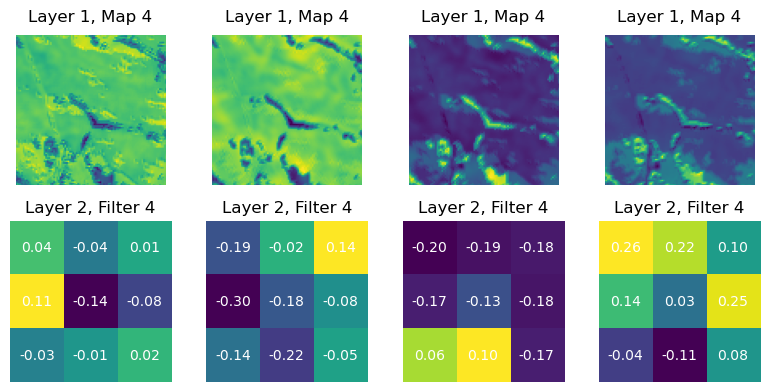

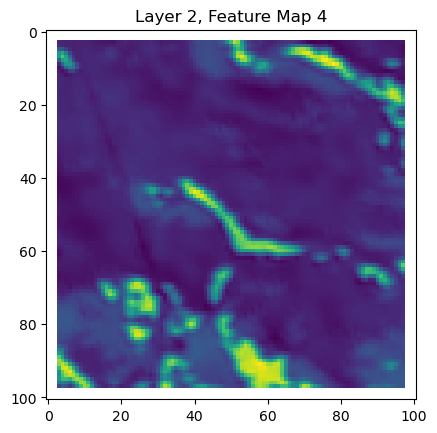

In [449]:
# -------------------------------------------------------------------------
# Extract the weights (filters) from the second convolution layer in conv_habitat
# -------------------------------------------------------------------------
filters_c2 = model.conv_habitat.conv2d[2].weight.data.clone().cpu()
print("Filters shape:", filters_c2.shape)
# Typically (out_channels, in_channels, kernel_height, kernel_width)

# -------------------------------------------------------------------------
# Visualize each filter’s first channel in a grid of subplots
# -------------------------------------------------------------------------
num_filters_c2 = filters_c2.shape[1]
print(num_filters_c2)

for z in range(num_maps2):

    fig, axes = plt.subplots(2, num_filters_c2, figsize=(2*num_filters_c2, 4))
    for i in range(num_filters_c2):

        # Add the covariates as the first row of subplots
        axes[0,i].imshow(feat_maps1_sample[i].numpy() * x_mask * y_mask, cmap='viridis')
        axes[0,i].axis('off')
        axes[0,i].set_title(f"Layer 1, Map {z+1}")

        # if i > 3:
        #     im1 = axes[0,i].imshow(covariate_stack[0, i].detach().cpu().numpy(), cmap='viridis')
        #     im1.set_clim(-1, 1)
        #     axes[0,i].text(scalar_maps.shape[2] // 2, scalar_maps.shape[3] // 2, 
        #         f'Value: {round(x2[0, i-4].item(), 2)}', 
        #         ha='center', va='center', color='white', fontsize=12)

        kernel = filters_c2[z, i, :, :]  # Show the first input channel
        im = axes[1,i].imshow(kernel, cmap='viridis')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Layer 2, Filter {z+1}')
        # Annotate each cell with the numeric value
        for (j, k), val in np.ndenumerate(kernel):
            axes[1,i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer2_filters{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()

        
    # -----------------------------------------------------------
    # 6. Loop over each feature map channel and save them as images.
    #    Multiply by x_mask * y_mask if you need to mask out edges.
    # -----------------------------------------------------------

    plt.figure()
    plt.imshow(feat_maps2_sample[z].numpy() * x_mask * y_mask, cmap='viridis')
    plt.title(f"Layer 2, Feature Map {z+1}")
    # Hide axis if you prefer: plt.axis('off')
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer2_feature_map{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()



## Convolutional layer 3

### Activation hook

In [442]:
# -----------------------------------------------------------
# Register a forward hook on the third convolution layer 
#    in the model's 'conv_habitat' block
# -----------------------------------------------------------
model.conv_habitat.conv2d[4].register_forward_hook(get_activation("hab_conv3"))

# -----------------------------------------------------------
# Perform a forward pass through the model with the desired input
#    The feature maps from the hooked layer will be stored in 'activation'
# -----------------------------------------------------------
out = model((x1, x2, x3))  # e.g., model((spatial_data_x, scalars_to_grid, bearing_x))

# -----------------------------------------------------------
# Retrieve the captured feature maps from the dictionary
#    and move them to the CPU for inspection
# -----------------------------------------------------------
feat_maps3 = activation["hab_conv3"].cpu()
print("Feature map shape:", feat_maps3.shape)
# Typically shape: (batch_size, out_channels, height, width)

# -----------------------------------------------------------
# Visualize the feature maps for the first sample in the batch
# -----------------------------------------------------------
feat_maps3_sample = feat_maps3[0]  # Shape: (out_channels, H, W)
num_maps3 = feat_maps3_sample.shape[0]
print("Number of feature maps:", num_maps3)



Feature map shape: torch.Size([1, 1, 101, 101])
Number of feature maps: 1


### Extract filters and plot

Filters shape: torch.Size([1, 4, 3, 3])
4


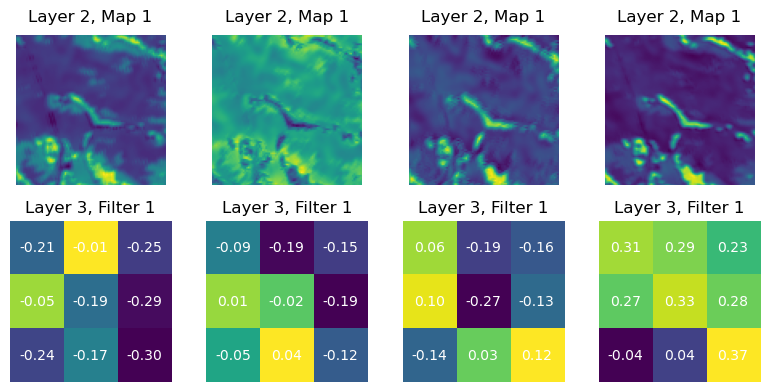

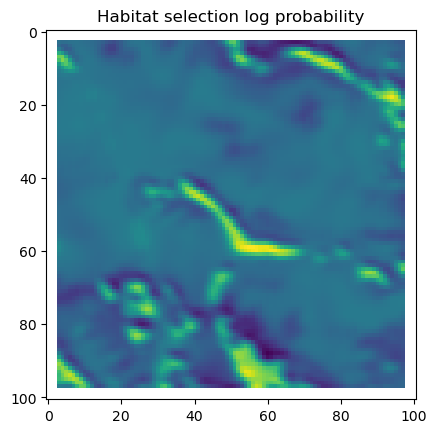

In [443]:
# -------------------------------------------------------------------------
# Extract the weights (filters) from the second convolution layer in conv_habitat
# -------------------------------------------------------------------------
filters_c3 = model.conv_habitat.conv2d[4].weight.data.clone().cpu()
print("Filters shape:", filters_c3.shape)
# Typically (out_channels, in_channels, kernel_height, kernel_width)

# -------------------------------------------------------------------------
# Visualize each filter’s first channel in a grid of subplots
# -------------------------------------------------------------------------
num_filters_c3 = filters_c3.shape[1]
print(num_filters_c3)

for z in range(num_maps3):

    fig, axes = plt.subplots(2, num_filters_c3, figsize=(2*num_filters_c3, 4))
    for i in range(num_filters_c3):

        # Add the covariates as the first row of subplots
        axes[0,i].imshow(feat_maps2_sample[i].numpy() * x_mask * y_mask, cmap='viridis')
        axes[0,i].axis('off')
        axes[0,i].set_title(f"Layer 2, Map {z+1}")


        kernel = filters_c3[z, i, :, :]  # Show the first input channel
        im = axes[1,i].imshow(kernel, cmap='viridis')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Layer 3, Filter {z+1}')
        # Annotate each cell with the numeric value
        for (j, k), val in np.ndenumerate(kernel):
            axes[1,i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer3_filters{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()

        
    # -----------------------------------------------------------
    # 6. Loop over each feature map channel and save them as images.
    #    Multiply by x_mask * y_mask if you need to mask out edges.
    # -----------------------------------------------------------

    plt.figure()
    plt.imshow(feat_maps3_sample[z].numpy() * x_mask * y_mask, cmap='viridis')
    plt.title(f"Habitat selection log probability")
    # Hide axis if you prefer: plt.axis('off')
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer3_feature_map{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()



# Checking estimated movement parameters

Similarly to the convolutional layers, we can set hooks to extract the predicted movement parameters from the model, and assess how variable that is across samples.

In [444]:
# -------------------------------------------------------------------------
# Create a list to store the intermediate output from the fully connected
#    movement sub-network (fcn_movement_all)
# -------------------------------------------------------------------------
intermediate_output = []

def hook(module, input, output):
    """
    Hook function that captures the output of the specified layer
    (fcn_movement_all) during the forward pass.
    """
    intermediate_output.append(output)

# -------------------------------------------------------------------------
# Register the forward hook on 'fcn_movement_all', so its outputs
#    are recorded every time the model does a forward pass.
# -------------------------------------------------------------------------
hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# -------------------------------------------------------------------------
# Perform a forward pass with the model in evaluation mode, 
#    disabling gradient computation.
# -------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    final_output = model((x1, x2, x3))

# -------------------------------------------------------------------------
# Inspect the captured intermediate output
#    'intermediate_output[0]' corresponds to the first (and only) forward pass.
# -------------------------------------------------------------------------
print("Intermediate output shape:", intermediate_output[0].shape)
print("Intermediate output values:", intermediate_output[0][0])

# -------------------------------------------------------------------------
# Remove the hook to avoid repeated capturing in subsequent passes
# -------------------------------------------------------------------------
hook_handle.remove()

# -------------------------------------------------------------------------
# Unpack the parameters from the FCN output (assumes a specific ordering)
# -------------------------------------------------------------------------
gamma_shape1, gamma_scale1, gamma_weight1, \
gamma_shape2, gamma_scale2, gamma_weight2, \
vonmises_mu1, vonmises_kappa1, vonmises_weight1, \
vonmises_mu2, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]

# -------------------------------------------------------------------------
# Convert parameters from log-space (if applicable) and print them
#    Gamma and von Mises parameters
# -------------------------------------------------------------------------
# --- Gamma #1 ---
print("Gamma shape 1:", torch.exp(gamma_shape1))
print("Gamma scale 1:", torch.exp(gamma_scale1))
print("Gamma weight 1:",
      torch.exp(gamma_weight1) / (torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# --- Gamma #2 ---
print("Gamma shape 2:", torch.exp(gamma_shape2))
print("Gamma scale 2:", torch.exp(gamma_scale2) * 500)  # scale factor 500
print("Gamma weight 2:",
      torch.exp(gamma_weight2) / (torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# --- von Mises #1 ---
# % (2*np.pi) ensures the mu (angle) is wrapped within [0, 2π)
print("Von Mises mu 1:", vonmises_mu1 % (2*np.pi))
print("Von Mises kappa 1:", torch.exp(vonmises_kappa1))
print("Von Mises weight 1:",
      torch.exp(vonmises_weight1) / (torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))

# --- von Mises #2 ---
print("Von Mises mu 2:", vonmises_mu2 % (2*np.pi))
print("Von Mises kappa 2:", torch.exp(vonmises_kappa2))
print("Von Mises weight 2:",
      torch.exp(vonmises_weight2) / (torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))


Intermediate output shape: torch.Size([1, 12])
Intermediate output values: tensor([ 0.4088,  0.6352,  0.4220, -1.9007, -0.2053,  0.0155,  0.0020,  0.8821,
         0.0316,  0.2016, -0.9737,  0.3697])
Gamma shape 1: tensor(1.5050)
Gamma scale 1: tensor(1.8873)
Gamma weight 1: tensor(0.6003)
Gamma shape 2: tensor(0.1495)
Gamma scale 2: tensor(407.2140)
Gamma weight 2: tensor(0.3997)
Von Mises mu 1: tensor(0.0020)
Von Mises kappa 1: tensor(2.4160)
Von Mises weight 1: tensor(0.4163)
Von Mises mu 2: tensor(0.2016)
Von Mises kappa 2: tensor(0.3777)
Von Mises weight 2: tensor(0.5837)


## Plot the movement distributions

We can use the movement parameters to plot the step length and turning angle distributions for the sample covariates.

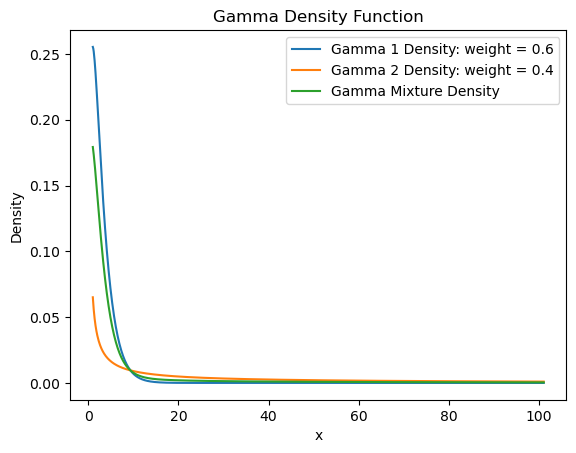

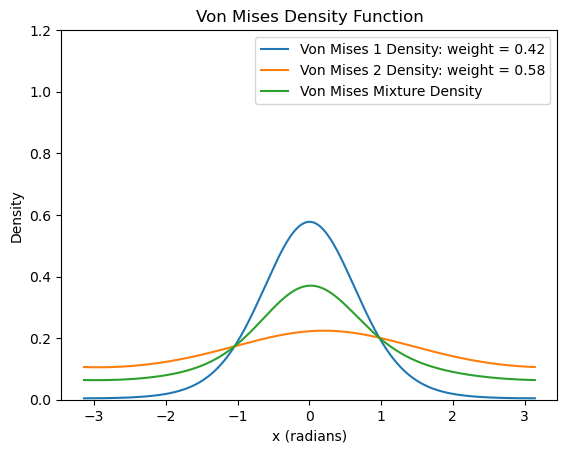

In [445]:
# -------------------------------------------------------------------------
# Define helper functions for calculating Gamma and von Mises log-densities
# -------------------------------------------------------------------------
def gamma_density(x, shape, scale):
    """
    Computes the log of the Gamma density for each value in x.

    Args:
      x (Tensor): Input values for which to compute the density.
      shape (float): Gamma shape parameter
      scale (float): Gamma scale parameter

    Returns:
      Tensor: The log of the Gamma probability density at each x.
    """
    return -1*torch.lgamma(shape) - shape*torch.log(scale) \
           + (shape - 1)*torch.log(x) - x/scale

def vonmises_density(x, kappa, vm_mu):
    """
    Computes the log of the von Mises density for each value in x.

    Args:
      x (Tensor): Input angles in radians.
      kappa (float): Concentration parameter (kappa)
      vm_mu (float): Mean direction parameter (mu)

    Returns:
      Tensor: The log of the von Mises probability density at each x.
    """
    return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


# -------------------------------------------------------------------------
# Round and display the mixture weights for the Gamma distributions
# -------------------------------------------------------------------------
gamma_weight1_recovered = torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight1 = round(gamma_weight1_recovered.item(), 2)

gamma_weight2_recovered = torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight2 = round(gamma_weight2_recovered.item(), 2)

# -------------------------------------------------------------------------
# Round and display the mixture weights for the von Mises distributions
# -------------------------------------------------------------------------
vonmises_weight1_recovered = torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight1 = round(vonmises_weight1_recovered.item(), 2)

vonmises_weight2_recovered = torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight2 = round(vonmises_weight2_recovered.item(), 2)


# -------------------------------------------------------------------------
# 1. Plotting the Gamma mixture distribution
#    a) Generate x values
#    b) Compute individual Gamma log densities
#    c) Exponentiate and combine using recovered weights
# -------------------------------------------------------------------------
x_values = torch.linspace(1, 101, 1000).to(device)
gamma1_density = gamma_density(x_values, torch.exp(gamma_shape1), torch.exp(gamma_scale1))
gamma2_density = gamma_density(x_values, torch.exp(gamma_shape2), torch.exp(gamma_scale2)*500)
gamma_mixture_density = gamma_weight1_recovered*torch.exp(gamma1_density) \
                        + gamma_weight2_recovered*torch.exp(gamma2_density)

# Move results to CPU and convert to NumPy for plotting
x_values_np = x_values.cpu().numpy()
gamma1_density_np = np.exp(gamma1_density.cpu().numpy())
gamma2_density_np = np.exp(gamma2_density.cpu().numpy())
gamma_mixture_density_np = gamma_mixture_density.cpu().numpy()

# -------------------------------------------------------------------------
# 2. Plot the Gamma distributions and their mixture
# -------------------------------------------------------------------------
plt.plot(x_values_np, gamma1_density_np, label=f'Gamma 1 Density: weight = {rounded_gamma_weight1}')
plt.plot(x_values_np, gamma2_density_np, label=f'Gamma 2 Density: weight = {rounded_gamma_weight2}')
plt.plot(x_values_np, gamma_mixture_density_np, label='Gamma Mixture Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gamma Density Function')
plt.legend()
plt.show()


# -------------------------------------------------------------------------
# 3. Plotting the von Mises mixture distribution
#    a) Generate x values from -π to π
#    b) Compute individual von Mises log densities
#    c) Exponentiate and combine using recovered weights
# -------------------------------------------------------------------------
x_values = torch.linspace(-np.pi, np.pi, 1000).to(device)
vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), vonmises_mu1)
vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), vonmises_mu2)
vonmises_mixture_density = vonmises_weight1_recovered*torch.exp(vonmises1_density) \
                           + vonmises_weight2_recovered*torch.exp(vonmises2_density)

# Move results to CPU and convert to NumPy for plotting
x_values_np = x_values.cpu().numpy()
vonmises1_density_np = np.exp(vonmises1_density.cpu().numpy())
vonmises2_density_np = np.exp(vonmises2_density.cpu().numpy())
vonmises_mixture_density_np = vonmises_mixture_density.cpu().numpy()

# -------------------------------------------------------------------------
# 4. Plot the von Mises distributions and their mixture
# -------------------------------------------------------------------------
plt.plot(x_values_np, vonmises1_density_np, label=f'Von Mises 1 Density: weight = {rounded_vm_weight1}')
plt.plot(x_values_np, vonmises2_density_np, label=f'Von Mises 2 Density: weight = {rounded_vm_weight2}')
plt.plot(x_values_np, vonmises_mixture_density_np, label='Von Mises Mixture Density')
plt.xlabel('x (radians)')
plt.ylabel('Density')
plt.title('Von Mises Density Function')
plt.ylim(0, 1.2)  # Set a limit for the y-axis
plt.legend()
plt.show()


## Generate a distribution of movement parameters

To see how variable the movement parameters are across samples, we can generate a distribution of movement parameters from a batch of samples.

We take the code from above that we used to create the DataLoader for the test data and increase the batch size (to get more samples to create the distribution from).

As we're not using the test dataset any more, we'll just put all of the samples in the same batch, and generate movement parameters for all of them.

In [446]:
print(f'There are {len(dataset_train)} samples in the test dataset')
bs = len(dataset_train) # batch size
dataloader_train = DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True)

There are 8083 samples in the test dataset


In [447]:
# -----------------------------------------------------------
# Fetch a batch of data from the training dataloader
# -----------------------------------------------------------
x1_batch, x2_batch, x3_batch, labels = next(iter(dataloader_train))

# -----------------------------------------------------------
# Register a forward hook to capture the outputs 
#    from 'fcn_movement_all' during the forward pass
# -----------------------------------------------------------
hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# -----------------------------------------------------------
# Perform a forward pass in evaluation mode to generate 
#    and capture the sub-network's outputs in 'intermediate_output'
# -----------------------------------------------------------
model.eval()  # Disables certain layers like dropout

# Pass the batch through the model
final_output = model((x1_batch, x2_batch, x3_batch))

# -----------------------------------------------------------
# Prepare lists to store the distribution parameters 
#    for each sample in the batch
# -----------------------------------------------------------
gamma_shape1_list = []
gamma_scale1_list = []
gamma_weight1_list = []
gamma_shape2_list = []
gamma_scale2_list = []
gamma_weight2_list = []
vonmises_mu1_list = []
vonmises_kappa1_list = []
vonmises_weight1_list = []
vonmises_mu2_list = []
vonmises_kappa2_list = []
vonmises_weight2_list = []

# -----------------------------------------------------------
# Extract parameters from 'intermediate_output' 
#    for every sample in the batch
# -----------------------------------------------------------
for batch_output in intermediate_output:
    # Each 'batch_output' corresponds to one forward pass;
    # it might contain multiple samples if the batch size > 1
    for sample_output in batch_output:
        # Unpack the 12 parameters of the Gamma and von Mises mixtures
        gamma_shape1, gamma_scale1, gamma_weight1, \
        gamma_shape2, gamma_scale2, gamma_weight2, \
        vonmises_mu1, vonmises_kappa1, vonmises_weight1, \
        vonmises_mu2, vonmises_kappa2, vonmises_weight2 = sample_output

        # Convert log-space parameters to real space, then store
        gamma_shape1_list.append(torch.exp(gamma_shape1).item())
        gamma_scale1_list.append(torch.exp(gamma_scale1).item())
        gamma_weight1_list.append(
            (torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item()
        )
        gamma_shape2_list.append(torch.exp(gamma_shape2).item())
        gamma_scale2_list.append((torch.exp(gamma_scale2)*500).item())  # scale factor 500
        gamma_weight2_list.append(
            (torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item()
        )
        vonmises_mu1_list.append((vonmises_mu1 % (2*np.pi)).item())
        vonmises_kappa1_list.append(torch.exp(vonmises_kappa1).item())
        vonmises_weight1_list.append(
            (torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item()
        )
        vonmises_mu2_list.append((vonmises_mu2 % (2*np.pi)).item())
        vonmises_kappa2_list.append(torch.exp(vonmises_kappa2).item())
        vonmises_weight2_list.append(
            (torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item()
        )


### Plot the distribution of movement parameters

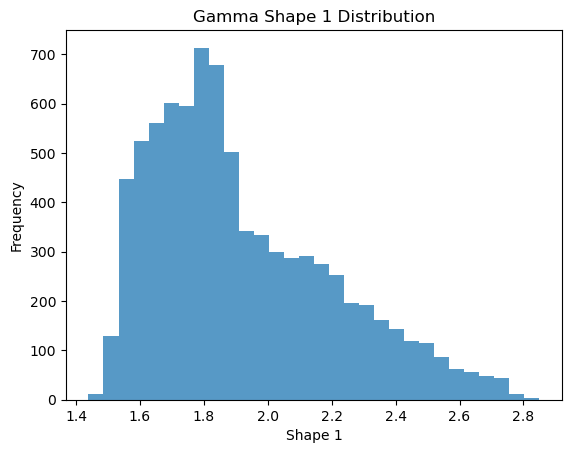

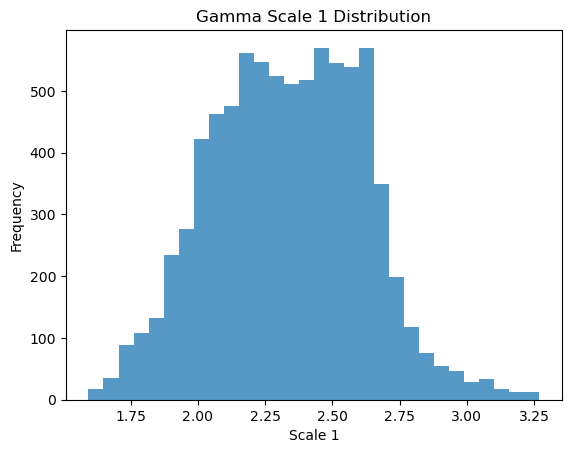

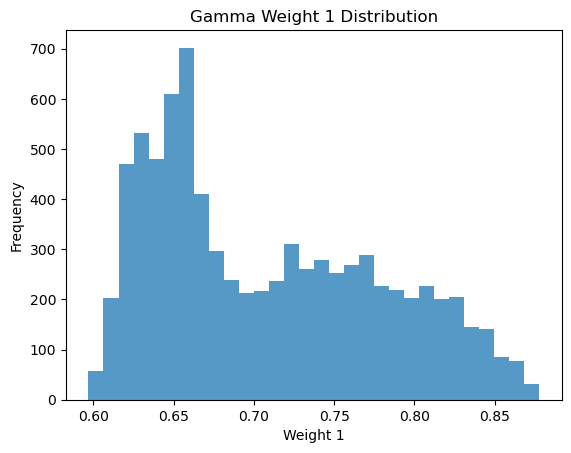

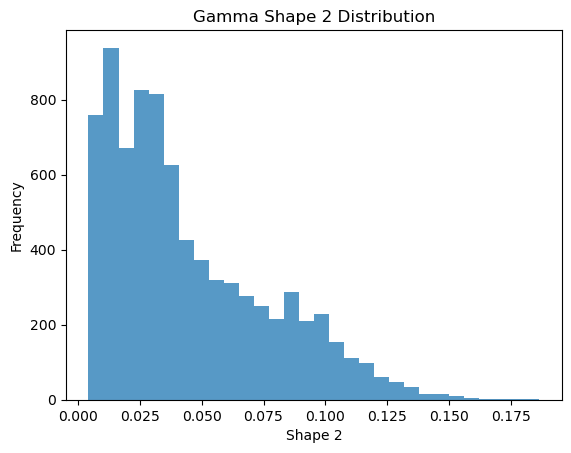

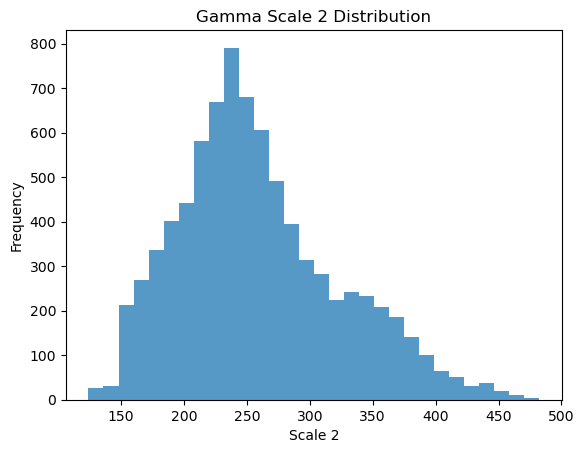

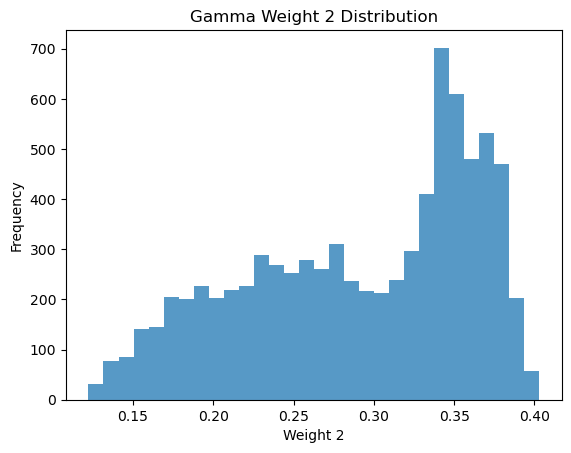

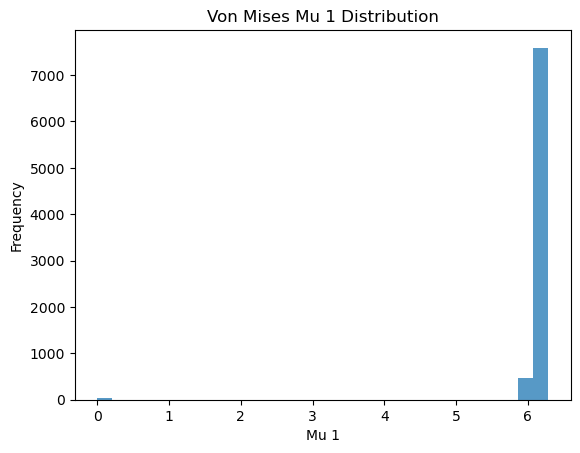

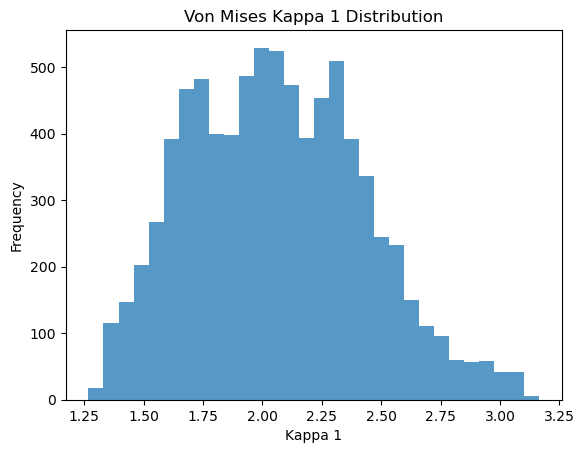

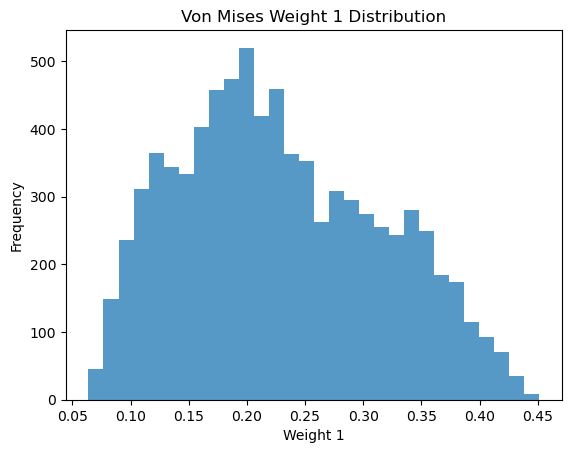

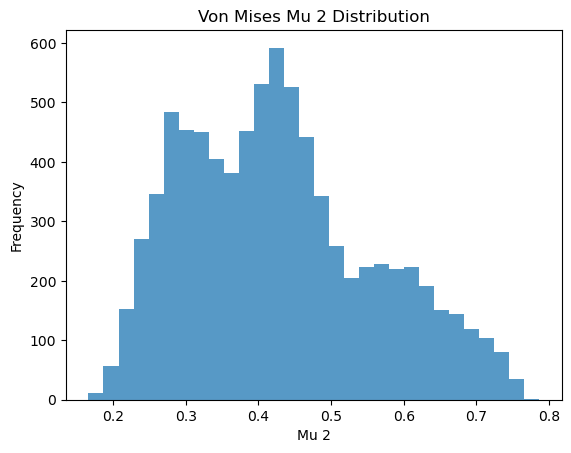

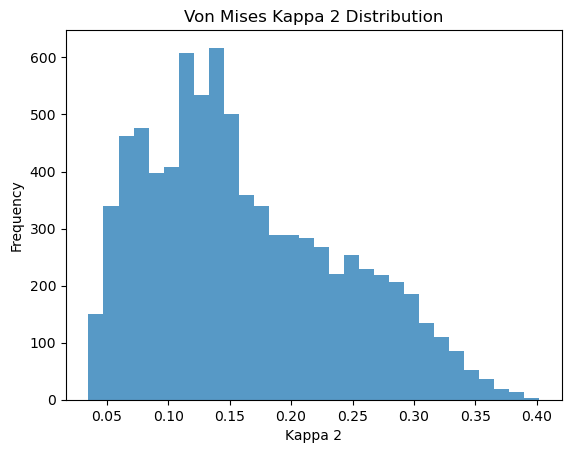

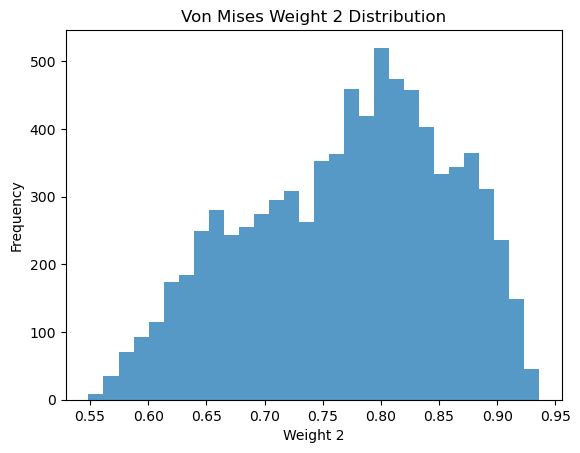

In [448]:
# -----------------------------------------------------------
# Define a helper function to plot histograms 
#    for the collected parameters
# -----------------------------------------------------------
def plot_histogram(data, title, xlabel):
    """
    Plots a histogram of the provided data.

    Args:
        data (list): Data points to plot in a histogram.
        title (str): Title of the histogram plot.
        xlabel (str): X-axis label.
    """
    plt.figure()
    plt.hist(data, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

# -----------------------------------------------------------
# Plot histograms for each parameter distribution
# -----------------------------------------------------------
plot_histogram(gamma_shape1_list, 'Gamma Shape 1 Distribution', 'Shape 1')
plot_histogram(gamma_scale1_list, 'Gamma Scale 1 Distribution', 'Scale 1')
plot_histogram(gamma_weight1_list, 'Gamma Weight 1 Distribution', 'Weight 1')
plot_histogram(gamma_shape2_list, 'Gamma Shape 2 Distribution', 'Shape 2')
plot_histogram(gamma_scale2_list, 'Gamma Scale 2 Distribution', 'Scale 2')
plot_histogram(gamma_weight2_list, 'Gamma Weight 2 Distribution', 'Weight 2')
plot_histogram(vonmises_mu1_list, 'Von Mises Mu 1 Distribution', 'Mu 1')
plot_histogram(vonmises_kappa1_list, 'Von Mises Kappa 1 Distribution', 'Kappa 1')
plot_histogram(vonmises_weight1_list, 'Von Mises Weight 1 Distribution', 'Weight 1')
plot_histogram(vonmises_mu2_list, 'Von Mises Mu 2 Distribution', 'Mu 2')
plot_histogram(vonmises_kappa2_list, 'Von Mises Kappa 2 Distribution', 'Kappa 2')
plot_histogram(vonmises_weight2_list, 'Von Mises Weight 2 Distribution', 'Weight 2')

# -----------------------------------------------------------
# Remove the hook to stop capturing outputs 
#    in subsequent forward passes
# -----------------------------------------------------------
hook_handle.remove()